__Author: Martin Ng__    
__Date: 010/02/21__

Purpose of this notebook is to carry out modelling on the POALoanData set.

Scikit-Learn modules would be heavily used.

# Load Dependencies

In [104]:
# data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import scipy.stats as ss
from joblib import dump, load
from re import search

# dependencies for preprocessing
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder, Binarizer, OneHotEncoder, QuantileTransformer, PowerTransformer , FunctionTransformer
from sklearn_pandas import DataFrameMapper, gen_features, NumericalTransformer

# dependencies for modelling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# evaluation
from sklearn.model_selection import GridSearchCV, cross_validate, validation_curve, learning_curve, StratifiedKFold, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve, plot_confusion_matrix, plot_det_curve
from sklearn.metrics import precision_recall_curve, roc_curve, det_curve, classification_report, confusion_matrix
from sklearn.metrics import matthews_corrcoef, brier_score_loss, f1_score, jaccard_score, log_loss, roc_auc_score, precision_score, recall_score

# dependencies for probability calibration
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# dependencies for imbalanced learn
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from imblearn.pipeline import Pipeline as Pipeline_sampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE, SMOTE
from imblearn.combine import SMOTEENN

# feature importances
from xgboost import plot_importance as xgb_plot_importance


# Load Functions

In [88]:
# Load utility functions

def load_and_split(url):
    '''
    Returns X_train, y_train, X_test, y_test

    '''
    
    # Load dataset
    df = pd.read_csv(url, dtype={'NrOfDependants': str})
    # convert column names to lowercase
    df.columns = df.columns.str.lower()
    # convert date column to datetime
    df['loanapplicationstarteddate'] = pd.to_datetime(df['loanapplicationstarteddate'], format='%Y-%m-%d %H:%M:%S')
    # drop unused columns, variables
    drop_cols = ['interest', 'noofearlierdefaults', 'incomefromothers', 'incomefromsalary']
    
    df = df.drop(columns=drop_cols)
    # sort df according to date
    df = df.sort_values(by='loanapplicationstarteddate', ignore_index=True)

    # Test-train split
    train, test = np.split(df, [int(0.8 *len(df))])

    # x-y split
    X_train, y_train = train.loc[:, ~train.columns.isin(['defaulted'])].copy(), train['defaulted'].copy()
    X_test, y_test = test.loc[:, ~test.columns.isin(['defaulted'])].copy(), test['defaulted'].copy()
    
    return X_train, y_train, X_test, y_test
    
    
def prepare_db(num_var, cat_var, dtype_dict):
    '''
    Returns db, the database dataframe
    
    '''
    
    # load database
    db = pd.read_csv("../../../Data/Processed/Database.csv", dtype={'nrofdependants': str})
    db.columns = db.columns.str.lower()
    db['loanapplicationstarteddate'] = pd.to_datetime(db['loanapplicationstarteddate'], format='%Y-%m-%d %H:%M:%S')
    db['defaultdate'] = pd.to_datetime(db['defaultdate'], format='%Y-%m-%d')
    db['loandate'] = pd.to_datetime(db['loandate'], format='%Y-%m-%d')
    
    # cast db data type
    db = dtype_cast(db, num_var, cat_var, dtype_dict)
    
    return db



def dtype_cast(df, num_var=None, cat_var=None, dtype_dict=None):
    '''
    Utility function to cast the appropriate data types to the variables.
    
    Returns the dataframe with the data types casted.
    
    '''
    
    df = df.copy()
    
    if num_var is None:
        
        df = df.astype(float)
    
    else:
        
        # cast numerical var to float
        df[num_var] = df[num_var].astype(float)
    
    if (cat_var is not None) & (dtype_dict is not None):
    
        for cat in cat_var:
            df[cat] = df[cat].astype(dtype_dict[cat+'_dtype'])

    return df


def custom_impute(df):
    '''
    Utility function to impute missing values in previousearlyrepaymentsbeforeloan according to specific condition.
    
    Returns dataframe with values imputed.
    
    '''

    df = df.copy()
    df.loc[(df['previousearlyrepaymentsbeforeloan'].isna() & (df['previousearlyrepaymentscountbeforeloan']==0)), 'previousearlyrepaymentsbeforeloan'] = 0

    return df
    

def fill_na(data, database, variables:list=None):
    '''
    A function that gets the latest non-nan values from a database and fills in the nan values in the data dataframe.
    
    By default, the function will fill search and fill all variable columns that have nan values, unless specified in the variables list.
    
    '''
    data = data.copy()
    database = database.copy()
    
    data_group_key = 'username'
    data_merge_col = 'loanid'
    
    
    database_group_key = data_group_key
    database_merge_col = data_merge_col
    database_date_col = 'loanapplicationstarteddate'
    
    if variables == None:
        variables  = data.columns[data.isna().sum()!=0]
    
        
    # get corresponding loans belonging to these usernames from database
    database_miss = database.loc[database[database_group_key].isin(set(data[data_group_key]))].copy()
    
    # sort these loans according to username and date
    database_miss = database_miss.sort_values([database_group_key, database_date_col])
    # implement a little trick here, we will use the fillna(method='ffill') method followed by pd.merge according to the loanid
    # to simulate the querying of database for ast records to impute, which is what we see in actual operation. 
    # For the test dataset, they will also have a view of the database

    # for each username group, find earlier non-nan values to impute nan values, i.e. fillna(method='ffill')
    for var in variables:
        database_miss[var] = database_miss.groupby(database_group_key)[var].ffill()
    

    # use pd.merge between data and db_df_miss on the loanid to simulate the querying
    data = pd.merge(data.reset_index(), database_miss[[database_merge_col, *variables]], how='left', left_on=data_merge_col, right_on=database_merge_col).set_index('index')
    
    for var in variables:
        data[var+'_x'] = data[var+'_y'].copy()
        data.drop(columns=[var+'_y'], inplace=True)
        data.rename(columns={var+'_x':var}, inplace=True)
    
    return data


class GroupImputer(BaseEstimator, TransformerMixin):
    '''
    Class used for imputing missing values in a pd.DataFrame using either mean or median of a group.
    
    Parameters
    ----------    
    group_cols : list
        List of columns used for calculating the aggregated value 
    target : str
        The name of the column to impute
    metric : str
        The metric to be used for remplacement, can be one of ['mean', 'median']
    Returns
    -------
    X : array-like
        The array with imputed values in the target column
    '''
    def __init__(self, group_cols, target, metric='mean'):
        
        assert metric in ['mean', 'median'], 'Unrecognized value for metric, should be mean/median'
        assert type(group_cols) == list, 'group_cols should be a list of columns'
        assert type(target) == str, 'target should be a string'
        
        self.group_cols = group_cols
        self.target = target
        self.metric = metric
        
    
    def fit(self, X, y=None):
        
        assert pd.isnull(X[self.group_cols]).any(axis=None) == False, 'There are missing values in group_cols'
        
        
        impute_map = X.groupby(self.group_cols)[self.target].agg(self.metric) \
                                                            .reset_index(drop=False)
        
        self.impute_map_ = impute_map
        
        
        return self 
    
    def transform(self, X, y=None):
        
        # make sure that the imputer was fitted
        check_is_fitted(self, 'impute_map_')
        
        X = X.copy()
        
        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind, self.target] = X.loc[ind, self.target].fillna(row[self.target])
            
        return X

class variancethreshold(BaseEstimator, TransformerMixin):
    '''
    Class used for selecting columns from a pandas dataframe which have value variances above a threshold value.
    
    Parameters
    ----------    
    cols : list , default=None
        List of columns which will be tested for the variance threshold. Columns not in list will be
        passed untested.
        When default, all columns in the dataframe will be tested.
    threshold : float
        The threshold variance value below which the columns will be dropped.
        
    Returns
    -------
    x : Pandas datframe-like
        The dataframe with the columns having variances smaller than the threshold value dropped.
    '''

    def __init__(self, cols=None, threshold=0.0):
        
        assert type(cols) == list or cols is None, 'cols should be a list of columns or set to None'
        assert type(threshold) == float, 'threshold should be a float'
        
        from sklearn.feature_selection import VarianceThreshold

        self.threshold = threshold
        self.selector = VarianceThreshold(self.threshold)
        self.cols = cols

    def fit(self, x, y=None):
        
        if self.cols is None:
            self.selector.fit(x)
            fil = self.selector.get_support()
            cols_ = [i for (i, v) in zip(x.columns, fil) if v]
            
        else:
            self.selector.fit(x.loc[:,self.cols])
            fil = self.selector.get_support()
            cols_ = x.columns[~x.columns.isin(self.cols)].tolist() + [i for (i, v) in zip(self.cols, fil) if v]
            
        self.feature_names_ = cols_     
        
        return self

    def transform(self, x):
        
        # make sure that the imputer was fitted
        check_is_fitted(self, 'feature_names_')
        
        # return transformed columns
        x = x.loc[:, self.feature_names_]
        
        return x


In [89]:
# load evaluation functions

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        scoring=None, shuffle=False, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    scoring : str or callable, default=None
             A str (see model evaluation documentation) or
             a scorer callable object / function with signature
             ``scorer(estimator, X, y)``.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, shuffle=shuffle)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    
    plt.show()

    return plt


def eval_model(estimator, X_train, y_train, X_test, y_test, fitted=False):
    # fit estimator
    if not fitted:
        estimator.fit(X_train, y_train)
    
    if hasattr(estimator, 'predict_proba'):
        y_pred = estimator.predict_proba(X_test)
        logloss = log_loss(y_test, y_pred)
        brier = brier_score_loss(y_test, y_pred[:, 1])
        print(f'Log-loss: {logloss:.3f}')
        print(f'Brier score: {brier:.3f}\n')
    
    print(classification_report(y_test, estimator.predict(X_test)))

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(17, 5))

    plot_precision_recall_curve(estimator, X_test, y_test, ax=ax1)
    plot_roc_curve(estimator, X_test, y_test, ax=ax2)
    plot_confusion_matrix(estimator, X_test, y_test, ax=ax3)

    plt.show()
    
    
def score_cv_result(cv_result, clf_name=None, verbose=False):
    
    import re
    
    r = re.compile("test_")
    scoring = list(filter(r.match, cv_result.keys()))
    
    scores = {}

    # print scores
    for score in scoring:
        print(f'{score.split("test_")[1].capitalize()} avg score: {cv_result[score].mean():.3f}, sd: {cv_result[score].std():.3f}')
        scores[f'{score.split("test_")[1].capitalize()}'] = np.round(cv_result[score].mean(), 3)

        if verbose:
            print(f'Fold scores: {cv_result[score]}\n')

    if clf_name is not None:
        scores_df = pd.DataFrame(scores, columns=scores.keys(), index=[clf_name])
        
        return scores_df
    

In [90]:
# load preprocessor maker

def make_preprocessor():   
    
    ###### local variables ######
    # dtype dict for datatype casting
    dtype_dict = {
        'gender_dtype' : pd.api.types.CategoricalDtype(list(range(0,3)), False),
        'homeownershiptype_dtype': pd.api.types.CategoricalDtype(list(range(0,11)), False),
        'languagecode_dtype': pd.api.types.CategoricalDtype([-1, 1, 2, 3, 4, 6, 9], False),
        'maritalstatus_dtype': pd.api.types.CategoricalDtype([e for e in range(-1, 6) if e !=0], False),
        'country_dtype' : pd.api.types.CategoricalDtype(['EE', 'FI', 'ES','SK'], False),
        'employmentstatus_dtype' : pd.api.types.CategoricalDtype([e for e in range(-1, 7) if e !=0], False),
        'occupationarea_dtype' : pd.api.types.CategoricalDtype([e for e in range(-1, 20) if e !=0], False),
        'nrofdependants_dtype' : pd.api.types.CategoricalDtype(['-1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '10Plus'], True),
        'employmentdurationcurrentemployer_dtype' : pd.api.types.CategoricalDtype(['Retiree', 'Other', 'TrialPeriod','UpTo1Year', 'UpTo2Years', 
                                                                                   'UpTo3Years', 'UpTo4Years', 'UpTo5Years', 'MoreThan5Years'], True),
        'education_dtype' : pd.api.types.CategoricalDtype(list(range(1,6)), True),
        'workexperience_dtype' : pd.api.types.CategoricalDtype(['-1','LessThan2Years','2To5Years','5To10Years','10To15Years','15To25Years',
                                                                'MoreThan25Years'], True)
    }
    # categorical variables
    cat_var = ['gender', 'homeownershiptype','languagecode', 'maritalstatus', 'nrofdependants', 'country',
               'education', 'employmentdurationcurrentemployer', 'employmentstatus','occupationarea', 'workexperience']
    # numerical variables
    num_var = ['age', 'appliedamount', 'loanduration', 'incometotal','noofpreviousloansbeforeloan',
               'amountofpreviousloansbeforeloan', 'priorrepayments', 'previousearlyrepaymentsbeforeloan',
               'previousearlyrepaymentscountbeforeloan', 'debttoincome', 'existingliabilities', 'liabilitiestotal']
    
    # others
    other_var = ['loanid', 'username', 'loanapplicationstartdate']
    # database for fill_na function
    db = prepare_db(num_var, cat_var, dtype_dict)
    
    ####### datatype casting ######
    
    ## functiontransfomer instance for dtype casting   
    dtypecast = FunctionTransformer(dtype_cast, kw_args={'num_var': num_var, 'cat_var': cat_var, 'dtype_dict': dtype_dict})
    
    
    ####### missing value imputation #######
    
    ## variables to declare
    # cat_cols to impute for missing values
    col_imp_1 = ['languagecode', 'employmentstatus', 'occupationarea']
    col_imp_2 = ['nrofdependants', 'workexperience']
    col_imp_mode = ['homeownershiptype', 'education', 'employmentdurationcurrentemployer']
    # sklearn pandas dataframemapper features
    # impute with -1
    imp_1 = gen_features(
        columns=[[x] for x in col_imp_1],
        classes=[{'class': SimpleImputer,
                  'strategy': 'constant', 
                  'fill_value': -1}])
    # impute with '-1'
    imp_2 = gen_features(
        columns=[[x] for x in col_imp_2],
        classes=[{'class': SimpleImputer, 
                  'strategy': 'constant', 
                  'fill_value': '-1'}])
    # impute with mode
    imp_mode = gen_features(
        columns=[[x] for x in col_imp_mode],
        classes=[{'class': SimpleImputer, 
                  'strategy': 'most_frequent'}]) 
    
    
    ##1. functiontransfomer instance for fill_na 
    fillna = FunctionTransformer(fill_na, kw_args={'database':db})
    
    ##2. missing value imputer instance for selected cat_cols
    cat_imputer = DataFrameMapper(features=imp_1+imp_2+imp_mode, default=None,df_out=True) 
    
    ##3. missing value imputer instance for selected num_cols
    num_imputer = make_pipeline(FunctionTransformer(custom_impute),
                                GroupImputer(group_cols=['previousearlyrepaymentscountbeforeloan'],
                                             target='previousearlyrepaymentsbeforeloan',
                                             metric='median'),
                                DataFrameMapper([(['previousearlyrepaymentsbeforeloan'], SimpleImputer(strategy='median'))],
                                                default=None,
                                                df_out=True))
    
    
    
    ######### categorical encoding ########
    
    ## var to declare
    col_nom = ['gender', 'homeownershiptype','languagecode', 'maritalstatus',
               'country', 'employmentstatus','occupationarea']
    col_ord = ['nrofdependants', 'education', 'employmentdurationcurrentemployer', 'workexperience']
    # generate sklearn pandas dataframemapper features
    # ordinal encoder
    ord_enc = []
    for col in col_ord:
        ord_enc += gen_features(
            columns=[[col]],
            classes=[{'class': OrdinalEncoder, 
                      'categories':  [dtype_dict[col+'_dtype'].categories.values],
                      'handle_unknown': 'use_encoded_value',
                      'unknown_value': np.nan}])
    # onehotencoder
    onehot_enc = []
    for col in col_nom:
        onehot_enc += gen_features(
            columns=[[col]],
            classes=[{'class': OneHotEncoder,
                      'categories':  [dtype_dict[col+'_dtype'].categories.values],
                      'sparse': False, 
                      'drop': 'first', # drop first {None, 'first', 'if_binary'}
                      'handle_unknown': 'error'}])
    
    
    ## encoder + drop_cols
    encoder = DataFrameMapper(features=ord_enc+onehot_enc,
                              default=None,
                              df_out=True)
    
    
    ##### remove zero variance features #####
    ## variables to declare
    # update num_var list
    num_var_1 = ['age', 'appliedamount', 'loanduration', 'incometotal','noofpreviousloansbeforeloan',
               'amountofpreviousloansbeforeloan', 'priorrepayments', 'previousearlyrepaymentsbeforeloan',
               'previousearlyrepaymentscountbeforeloan', 'debttoincome', 'existingliabilities', 'liabilitiestotal']
    selector = variancethreshold(num_var_1)
    

     
    ####### Feature engineering #######
    ## variables to declare
    binarize_var = ['noofpreviousloansbeforeloan', 'amountofpreviousloansbeforeloan', 'priorrepayments', 
                    'previousearlyrepaymentsbeforeloan','previousearlyrepaymentscountbeforeloan',
                    'debttoincome', 'liabilitiestotal']
    bin_3 = ['existingliabilities']
    bin_4 = ['age']
    bin_5 = ['loanduration']
    bin_6 = ['incometotal']
    bin_10 = ['appliedamount']
    
    # sklearn pandas dataframemapper features
    # yeo transformation        
    yeo_tf = gen_features(
        columns=[[col] for col in num_var_1],
        classes=[{'class': StandardScaler,
                  'with_std': False},
                 {'class': PowerTransformer,
                  'method': 'yeo-johnson',
                  'standardize': True}],
        suffix='_yeo')
    # quantile transformation
    quantile_tf = gen_features(
        columns=[[col] for col in num_var_1],
        classes=[{'class': QuantileTransformer,
                  'output_distribution': 'uniform',
                  'random_state': 0}],
        suffix='_quantile')
    # log1p transformation
    log_tf = gen_features(
        columns=[[col] for col in num_var_1],
        classes=[{'class': NumericalTransformer,
                  'func': 'log1p'}],
        suffix='_log')
    # binarizer
    binar_tf = gen_features(
        columns=[[x] for x in binarize_var],
        classes=[{'class': Binarizer,
                  'threshold': 0}],
        suffix='_binned')    
    # binner
    binner_tf = []
    for bins in [3,4,5,6,10]:
        binner_tf += gen_features(
            columns=[[x] for x in eval('bin_'+str(bins))],
            classes=[{'class': KBinsDiscretizer,
                      'n_bins': bins,
                      'encode': 'ordinal',
                      'strategy': 'uniform'}],
            suffix='_binned')
    # column to keep
    col_keep = gen_features(
        columns=num_var_1,
        classes=None)
      
    
    
    #### cols to keep/drop etc ####
    drop_cols = ['loanid', 'username', 'loanapplicationstarteddate']

    
    ## transform all num_cols
    num_tf = DataFrameMapper(features=yeo_tf+quantile_tf+log_tf+binar_tf+binner_tf+col_keep,
                             default=None,
                             df_out=True,
                             drop_cols=drop_cols)
    
    
    ##### datatype casting ####
    
    ## functiontransfomer instance for dtype casting   
    dtypecast2 = FunctionTransformer(dtype_cast, kw_args={'num_var': None, 'cat_var': None, 'dtype_dict': None})
    
    
    
    ######### final preprocessor pipeline #########
    preprocessor = make_pipeline(dtypecast, # cast all variables to appropriate datatypes
                                 fillna, # fillna using custom function for missing value treatment
                                 cat_imputer, # missing value treatment for categorical variables
                                 dtypecast, # cast datatypes again
                                 num_imputer, # missing value treatment for numerical variables
                                 encoder, # encode categorical variables 
                                 num_tf, # generate transformations for numerical variables & drop_cols 
                                 dtypecast2 # dtypecast
                                )

    return preprocessor

In [98]:

def plot_validation_curve(train_scores, test_scores, title, parameter_name, log=True):

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    fig, ax = plt.subplots(figsize=(10,10))

    plt.title(title)
    plt.xlabel(parameter_name)
    plt.ylabel("Score")
    # plt.ylim(0.0, 1.1)
    lw = 2
    if log:
        plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    else:
        plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    if log:
        plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                     color="navy", lw=lw)
    else:
        plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                     color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
    
# define utility function for testing
def run_eval(clf, clf_name, X=None, y=None, fit_params=None, draw=True):
    
    # cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # scoring metrics
    scoring = ['roc_auc', 'neg_log_loss', 'neg_brier_score', 'balanced_accuracy', 'f1', 'recall', 'precision']
    
    print(f'Evaluation of {clf_name}')
    
    if X is None or y is None:
        
        X = X_train
        y = y_train

    # run cross-validation
    results = cross_validate(clf, X, y, scoring=scoring, fit_params=fit_params, cv=cv, n_jobs=-1)

    # print scores
    result_df = score_cv_result(results, clf_name)
    
    if draw:

        # plot learning curve
        plot_learning_curve(clf, clf_name, X, y, cv=cv, scoring='neg_log_loss', n_jobs=-1)
    
    return result_df

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            

# define relaibility curve plotting function
def plot_reliability_curves(model, name, ax, X, y):
    '''
    Utility function that plots the reliability curve of a fitted model on
    the X and y data.
    
    '''
    # predict the class probabilities on X
    probs = model.predict_proba(X)[:, 1]
    
    # calibration_curve returns the fraction of positives and 
    # mean predicted value
    fop, mpv = calibration_curve(y, probs, n_bins=10)
    
    # plot perfectly calibrated line, i.e. fop == mpv
    ax.plot([0, 1], [0, 1], linestyle='--', color='black')
    
    # plot model's reliability curve
    ax.plot(mpv, fop, marker='.', label=name)
    
    return ax


def optimise(clf, X, y):
    plt.style.use('ggplot')
    yhat = clf.predict_proba(X)
    # keep probabilities for the positive outcome only
    yhat = yhat[:, 1]
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y, yhat)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Logistic')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()


def evaluate_test(clf, clf_name, X, y, thres, draw=True, 
                   ax1=None, ax2=None, ax3=None ,):
    '''
    Final evaluation test.
    '''
    # score dict
    scores = {}

    print('Evaluating '+clf_name)
    # generate predicted probabilities
    y_pred_proba = clf.predict_proba(X)

    # generate binary prediction based on threshold
    y_pred_adj = [1 if y >= thres else 0 for y in y_pred_proba[:,1]]

    # calculate scores
    scores['Log Loss'] = log_loss(y, y_pred_proba)
    scores['Brier'] = brier_score_loss(y, y_pred_proba[:,1])
    scores['Roc Auc'] = roc_auc_score(y, y_pred_proba[:, 1])
    scores['F1'] = f1_score(y, y_pred_adj)
    scores['MCC'] = matthews_corrcoef(y, y_pred_adj)
    scores['Precision'] = precision_score(y, y_pred_adj)
    scores['Recall'] = recall_score(y, y_pred_adj)

    # results summary
    result = pd.DataFrame(scores, columns=scores.keys(), index=[clf_name])

    # plt.style.use('default')
    print(classification_report(y, y_pred_adj, digits=3))
    df_confusion = pd.crosstab(np.array(y), np.array(y_pred_adj), rownames=['Actual'], colnames=['Predicted'])
    print(confusion_matrix(y, y_pred_adj))
    # plot_confusion_matrix_(df_confusion, title='Confusion Matrix '+ clf_name)

    # plot curves
    if draw:
        if (ax1 is None) and (ax2 is None) and (ax3 is None):
            # set up canvas
            _, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 7))

        # roc_curve
        plot_roc_curve(clf, X, y, ax=ax1, name=clf_name)
        # det curve
        plot_det_curve(clf, X, y, ax=ax2, name=clf_name)
        # prec-recall
        plot_precision_recall_curve(clf, X, y, ax=ax3, name=clf_name)

#         ax1.legend().set_visible(False)
#         ax2.legend().set_visible(False)
#         ax3.legend().set_visible(False)
        
        ax1.legend().set_visible(True)
        ax2.legend().set_visible(True)
        ax3.legend().set_visible(True)


        return result, ax1, ax2, ax3

    return result


def plot_confusion_matrix_(df_confusion, title='Confusion matrix', cmap=plt.cm.Blues):
    '''
    Plot confusion matrix diagram without text
    
    '''
    
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

# Load & Prepare Data

In [5]:
# test_train split
X_train, y_train, X_test, y_test = load_and_split('../../../Data/Processed/POALoanData.csv')

In [6]:
# create model dictionary
models_dict = {}

# create result dataframe
result = pd.DataFrame()

In [7]:
# quick check on data
pp = make_preprocessor()
rrr = pp.fit_transform(X_train)
rrr.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57575 entries, 0 to 57574
Data columns (total 115 columns):
 #   Column                                           Dtype  
---  ------                                           -----  
 0   age_yeo                                          float64
 1   appliedamount_yeo                                float64
 2   loanduration_yeo                                 float64
 3   incometotal_yeo                                  float64
 4   noofpreviousloansbeforeloan_yeo                  float64
 5   amountofpreviousloansbeforeloan_yeo              float64
 6   priorrepayments_yeo                              float64
 7   previousearlyrepaymentsbeforeloan_yeo            float64
 8   previousearlyrepaymentscountbeforeloan_yeo       float64
 9   debttoincome_yeo                                 float64
 10  existingliabilities_yeo                          float64
 11  liabilitiestotal_yeo                             float64
 12  age_quantile     

# Baseline Performance - Naive Classifier

Lets begin by defining a baseline model and performance, using the DummyClassifier. With it, we have a number of classification strategy that we can adopt as the base performance:

1. Stratified - This uses the training set class distribution
2. Most frequent - This predicts the most frequent class of all cases
3. Prior - This predicts by maximizing the class prior

In [9]:
# instantiate transformers
preprocessor = make_preprocessor()
scaler = MinMaxScaler()

In [10]:
# turn off warnings
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

Evaluation of NaiveClf_stratified
Roc_auc avg score: 0.498, sd: 0.006
Neg_log_loss avg score: -12.084, sd: 0.138
Neg_brier_score avg score: -0.350, sd: 0.004
Balanced_accuracy avg score: 0.498, sd: 0.006
F1 avg score: 0.221, sd: 0.009
Recall avg score: 0.219, sd: 0.009
Precision avg score: 0.224, sd: 0.009


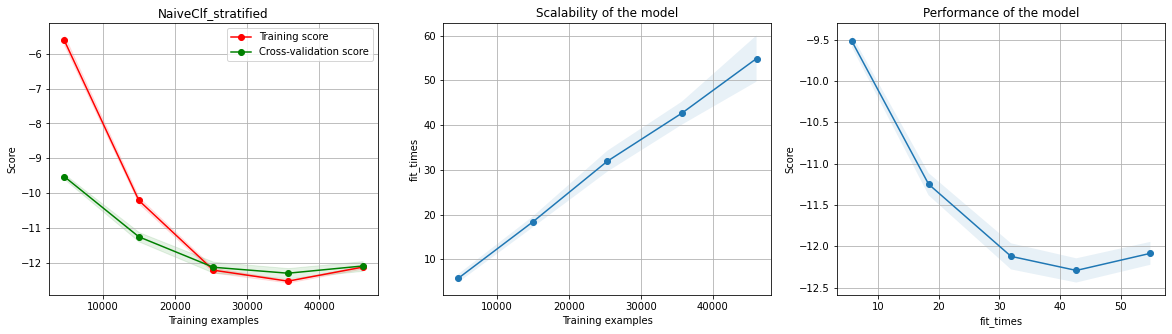

Evaluation of NaiveClf_most_frequent
Roc_auc avg score: 0.500, sd: 0.000
Neg_log_loss avg score: -7.861, sd: 0.001
Neg_brier_score avg score: -0.228, sd: 0.000
Balanced_accuracy avg score: 0.500, sd: 0.000
F1 avg score: 0.000, sd: 0.000
Recall avg score: 0.000, sd: 0.000
Precision avg score: 0.000, sd: 0.000


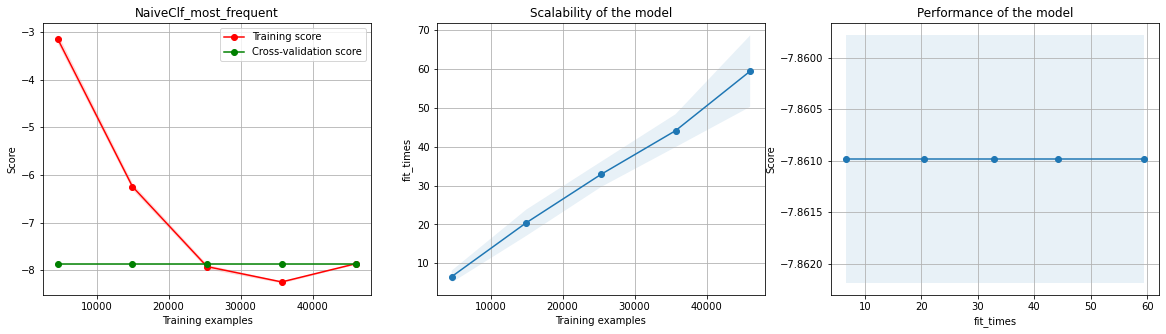

Evaluation of NaiveClf_prior
Roc_auc avg score: 0.500, sd: 0.000
Neg_log_loss avg score: -0.536, sd: 0.000
Neg_brier_score avg score: -0.176, sd: 0.000
Balanced_accuracy avg score: 0.500, sd: 0.000
F1 avg score: 0.000, sd: 0.000
Recall avg score: 0.000, sd: 0.000
Precision avg score: 0.000, sd: 0.000


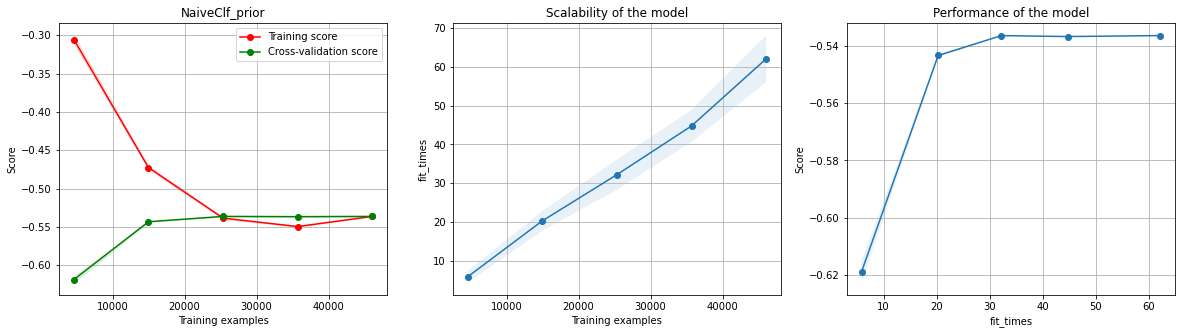

In [11]:
# instantiate naive classifier with stratified strategy
strategies = ['stratified', 'most_frequent', 'prior']


for strategy in strategies:
    estimator = DummyClassifier(strategy=strategy, random_state=42)
    # make classifier pipeline
    naive_clf = Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', scaler),
        ('estimator', estimator)]
    )

    result = pd.concat([result, run_eval(naive_clf, 'NaiveClf_'+strategy)])
    
    # store model in model dict
    models_dict['NaiveClf_'+strategy] = naive_clf
    
    # save model
    dump(naive_clf, '../../Model/Models/NaiveClf_'+strategy+'.joblib')

In [12]:
result

Roc_auc  Neg_log_loss  Neg_brier_score  \
NaiveClf_stratified       0.498       -12.084           -0.350   
NaiveClf_most_frequent    0.500        -7.861           -0.228   
NaiveClf_prior            0.500        -0.536           -0.176   

                        Balanced_accuracy     F1  Recall  Precision  
NaiveClf_stratified                 0.498  0.221   0.219      0.224  
NaiveClf_most_frequent              0.500  0.000   0.000      0.000  
NaiveClf_prior                      0.500  0.000   0.000      0.000

All 3 naive models converge with increasing training examples as expected, but the most_frequent and prior strategy produced warnings in the calculation of F1 and precision during some folds of the cross-validation as the classifier does not predict the positive classes. Thus, we will not place much emphasis on these metrics, but focus on the proper scoring metrics, such as negative log-loss and negative brier, which we would aim to maximise, i.e. optimise to get closer to 0.

Out of all 3 strategies, the prior strategy gives the best results, and would form our baseline performance. 

# Classification Models - Default Performance

Using the naive classifier as a baseline performance, we will explore the performance of other classifiers based on their default parameter settings.

We will consider the following models:

1. Logistic Regression - High intepretability, simple but powerful.
2. Decision Tree - Non-linear, handles categorical variables and collinearlity well, but tend to overfit.
2. Random Forest - Highly versatile, robust and intepretable, decision tree based ensemble
3. Gradient Boosted Trees - High performance, decision tree based ensemble

Evaluation of LR_default
Roc_auc avg score: 0.735, sd: 0.004
Neg_log_loss avg score: -0.473, sd: 0.003
Neg_brier_score avg score: -0.154, sd: 0.001
Balanced_accuracy avg score: 0.558, sd: 0.002
F1 avg score: 0.235, sd: 0.006
Recall avg score: 0.147, sd: 0.004
Precision avg score: 0.593, sd: 0.014


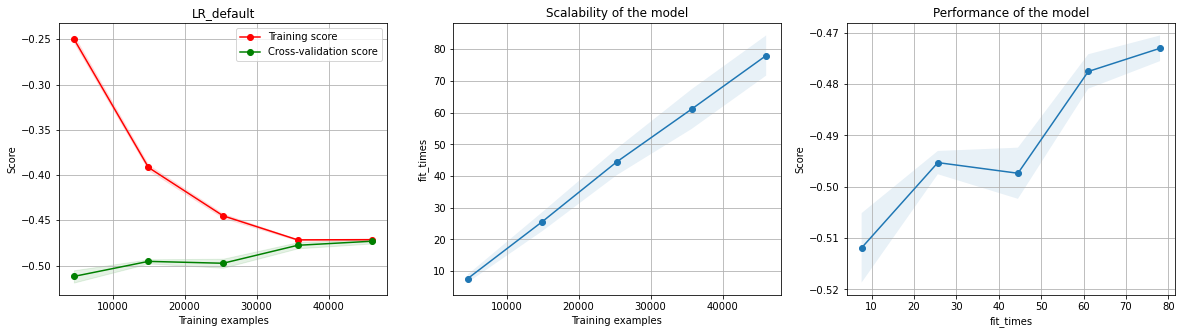

Evaluation of DT_default
Roc_auc avg score: 0.580, sd: 0.003
Neg_log_loss avg score: -10.477, sd: 0.038
Neg_brier_score avg score: -0.304, sd: 0.001
Balanced_accuracy avg score: 0.579, sd: 0.003
F1 avg score: 0.353, sd: 0.005
Recall avg score: 0.364, sd: 0.007
Precision avg score: 0.343, sd: 0.004


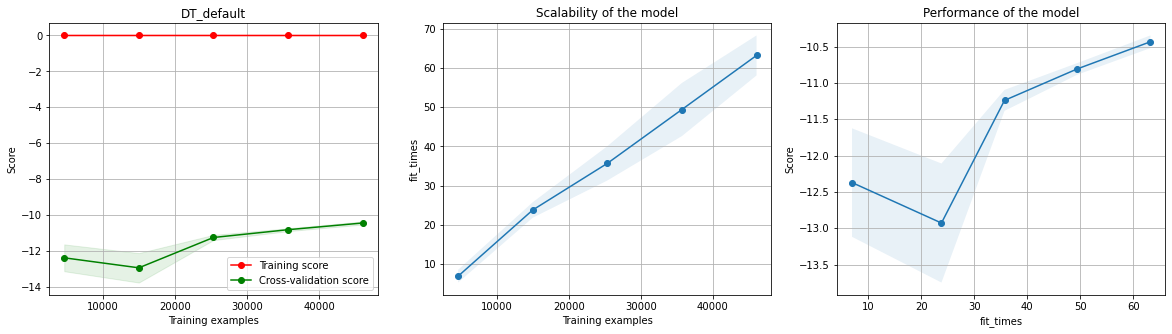

Evaluation of RF_default
Roc_auc avg score: 0.730, sd: 0.005
Neg_log_loss avg score: -0.487, sd: 0.005
Neg_brier_score avg score: -0.155, sd: 0.001
Balanced_accuracy avg score: 0.579, sd: 0.006
F1 avg score: 0.303, sd: 0.015
Recall avg score: 0.211, sd: 0.012
Precision avg score: 0.538, sd: 0.020


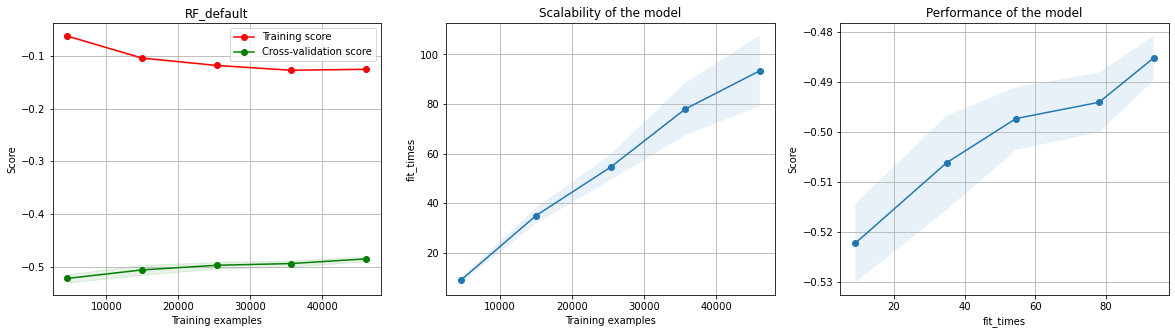

Evaluation of XGB_default
Roc_auc avg score: 0.745, sd: 0.004
Neg_log_loss avg score: -0.469, sd: 0.003
Neg_brier_score avg score: -0.151, sd: 0.001
Balanced_accuracy avg score: 0.583, sd: 0.003
F1 avg score: 0.309, sd: 0.008
Recall avg score: 0.211, sd: 0.007
Precision avg score: 0.578, sd: 0.013


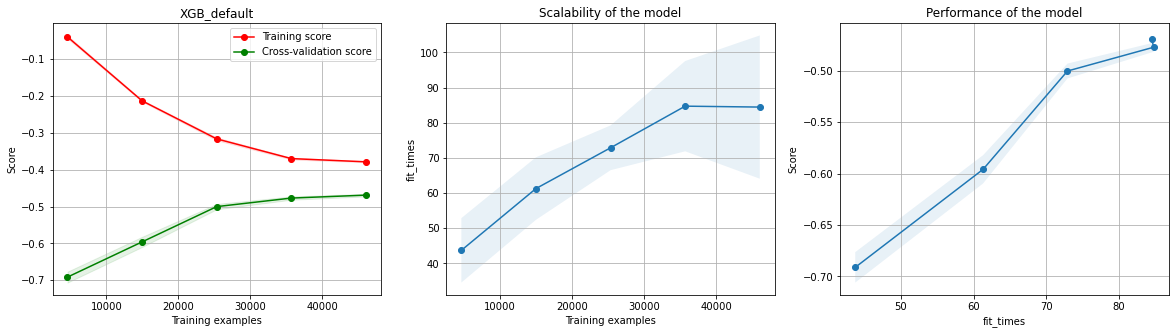

In [18]:
# instantiate transformers
preprocessor = make_preprocessor()
scaler = MinMaxScaler()

# instantiate estimators
lr = LogisticRegression(max_iter=1000)
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier(objective='binary:logistic', use_label_encoder=False)

models = {'LR': lr, 'DT': dt, 'RF': rf, 'XGB': xgb}

# evaluate estimators in to_scale
for k, estimator in models.items():
    
    if k == 'LR':
    
        clf = Pipeline([
            ('preprocessor', preprocessor),
            ('scaler', scaler), # scale features
            ('estimator', estimator)]
        )
    
    else:
        clf = Pipeline([
            ('preprocessor', preprocessor),
            ('estimator', estimator)]
        )
    
    result = pd.concat([result, run_eval(clf, k +'_default')])
    
    # store model in model dict
    models_dict[k+'_Default'] = clf
    
    # save model
    dump(clf, '../../Model/Models/'+k+'_Default.joblib')
    

In [19]:
result

Roc_auc  Neg_log_loss  Neg_brier_score  \
NaiveClf_stratified       0.498       -12.084           -0.350   
NaiveClf_most_frequent    0.500        -7.861           -0.228   
NaiveClf_prior            0.500        -0.536           -0.176   
LR_default                0.735        -0.473           -0.154   
DT_default                0.580       -10.477           -0.304   
RF_default                0.730        -0.487           -0.155   
XGB_default               0.745        -0.469           -0.151   

                        Balanced_accuracy     F1  Recall  Precision  
NaiveClf_stratified                 0.498  0.221   0.219      0.224  
NaiveClf_most_frequent              0.500  0.000   0.000      0.000  
NaiveClf_prior                      0.500  0.000   0.000      0.000  
LR_default                          0.558  0.235   0.147      0.593  
DT_default                          0.579  0.353   0.364      0.343  
RF_default                          0.579  0.303   0.211      0.538  
XGB_default                         0.583  0.309   0.211      0.578

Based on default parameters, we see that the few models seem to be performing better than naive classifier and others, based on ROC AUC, log-loss and brier score.

Front runners are XGB which have the greatest of the 3 metrics out of all the models. This is followed by LogisticRegression and RandomForest. 

DecisionTreeClassifier seem to be a mixed bag, peforming poorly (sometimes even poorer than the naive classifier) in some metrics).

We see that this is perhaps due to the overfitting of the DecisionTreeClassifier, as seen from the learning curve, where the training curve remains constantly high and there is a huge variance.

For the RandomForest, we see that the learning curves do not converge, which may indicate that further tuning can possibly improve the performance even further.

Next we will carry out some basic hyperparameter tuning and feature selection to further improve the performance of the models.

# Models Tuning

We will perform some parameter tuning. For the models, we will aim to maximise the neg log-loss.

## Logistic Regression

From the logistic regression learning curves, we see that the lines converge, indicating that the model had been fitted rather well. However, the overall high bias suggested that the model may not be complex enough fit the data.

For the tuning of the LR model, we will focus on a few parameters, namely the penalty and C value, which controls the regularisation strength and thus over/underfitting

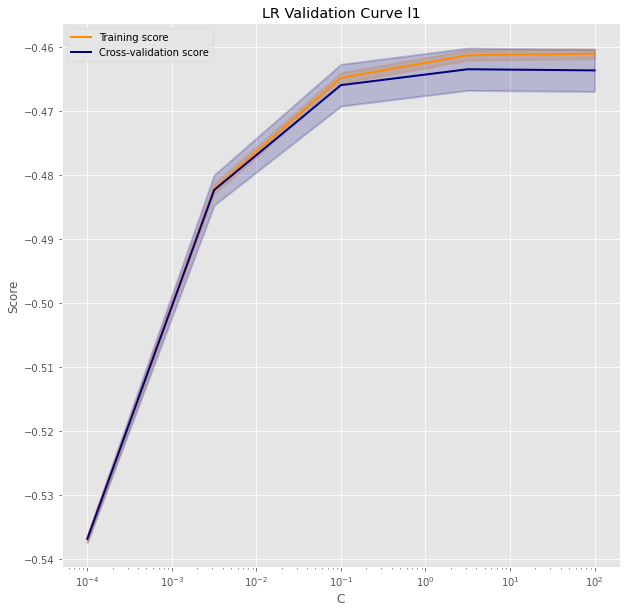

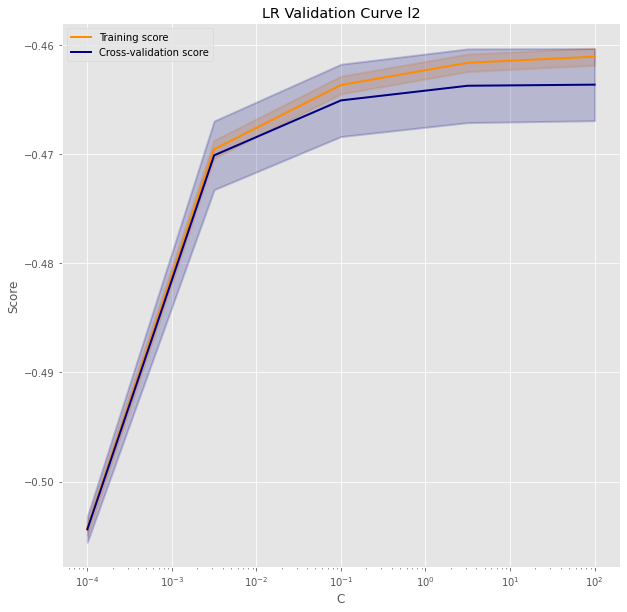

In [516]:
# instantiate preprocessor pipeline
preprocessor = make_preprocessor()

# instantiate cross-validation iterator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# generate a numpy array for the parameter values
param_range = np.logspace(-4, 2, 5)

# for l1 and l2 penalties
for penalty in ['l1', 'l2']:
    
    # make pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', MinMaxScaler()),
        # solver as saga as it allows for l1 and l2 penalty
        ('estimator', LogisticRegression(solver='saga', 
                                         penalty=penalty, 
                                         max_iter=1000))  
    ])
    
    # generate average cv train and test scores for each parameter 
    # value in the param_range
    train_scores, test_scores = validation_curve(
        pipe, X_train, y_train, param_name="estimator__C", 
        param_range=param_range, scoring="neg_log_loss",
        cv=cv, n_jobs=-1)
    
    # pass scores to a utility function that plots the curve
    plot_validation_curve(train_scores, test_scores,
                          'LR Validation Curve '+penalty,'C')

We see that the appropriate C is somewhere between 0.1 to 10 for both l1 and l2 penalty. It also seems that the l1 regularisation may be better performing.

In [520]:
# instantiate transformers
preprocessor = make_preprocessor()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# make pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler()),
    ('estimator', LogisticRegression(solver='saga', penalty='l1', max_iter=1000))
])

# parameter grid to pass into gridsearchcv
param_grid = {
    'estimator__C': np.logspace(-1,1, 10)
}

# gridsearchcv
grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_log_loss', cv=cv, n_jobs=-1)

start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

report(grid_search.cv_results_)

GridSearchCV took 1375.14 seconds for 10 candidate parameter settings.
Model with rank: 1
Mean validation score: -0.463 (std: 0.003)
Parameters: {'estimator__C': 3.593813663804626}

Model with rank: 2
Mean validation score: -0.463 (std: 0.003)
Parameters: {'estimator__C': 5.994842503189409}

Model with rank: 3
Mean validation score: -0.463 (std: 0.003)
Parameters: {'estimator__C': 2.1544346900318834}



Here we see that the most appropriate C value is 3.593813663804626.

## Decision Tree

For the decision tree, we see that the training curves remain constant at a rather high score while the cross-validation curve remains low and rises very slowly. The 2 curves do not converge. Overall, it was interpreted that the model had high bias and high variance and it is likely because of overfitting. Parameters (such as estimator__criterion, estimator__max_depth, estimator__max_features and estimator__min_impurity_decrease) can be optimised to control the complexity of the model to generalise and to improve the performance.

In [565]:
# instantiate transformers
preprocessor = make_preprocessor()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# make pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', DecisionTreeClassifier())
])

# parameter grid to pass into gridsearchcv
param_grid = {
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__min_impurity_decrease': ss.uniform(1e-4, 1.5e-3),
    'estimator__max_depth': [3, 4, 5, 6],
    'estimator__max_features': ss.uniform(0.6,0.2)
}


# run randomized search
n_iter_search = 30
random_search_dt = RandomizedSearchCV(pipe, param_distributions=param_grid, n_iter=n_iter_search, cv=cv, scoring='neg_log_loss', n_jobs=-1)

start = time()
random_search_dt.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search_dt.cv_results_)

RandomizedSearchCV took 1491.69 seconds for 30 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.469 (std: 0.003)
Parameters: {'estimator__criterion': 'entropy', 'estimator__max_depth': 6, 'estimator__max_features': 0.6218618170059151, 'estimator__min_impurity_decrease': 0.00029495461907492673}

Model with rank: 2
Mean validation score: -0.470 (std: 0.004)
Parameters: {'estimator__criterion': 'entropy', 'estimator__max_depth': 6, 'estimator__max_features': 0.6369718325750472, 'estimator__min_impurity_decrease': 0.0005051076047285952}

Model with rank: 3
Mean validation score: -0.471 (std: 0.003)
Parameters: {'estimator__criterion': 'gini', 'estimator__max_depth': 6, 'estimator__max_features': 0.7612806239321894, 'estimator__min_impurity_decrease': 0.0001458738018575407}



Based on the random search, we find that these are the best parameter settings:

## Random Forest

For the default random forest, we see an improvement compared to the decision tree, however, a based on the curves, we concluded that overfitting occurs too. Parameters such as n_estimators, max_depth, min_sample_leaf, max_features can be optimised to reduce the complexity and increase model performance.

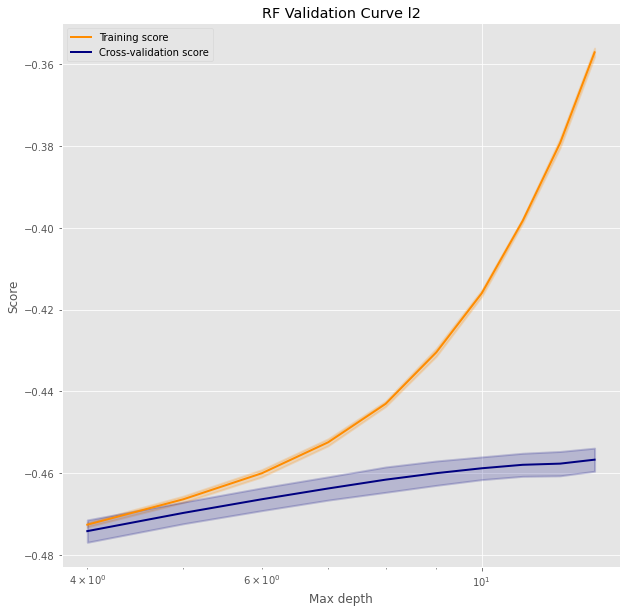

In [539]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, validation_curve 
from sklearn.pipeline import Pipeline

# instantiate preprocessor pipeline
preprocessor = make_preprocessor()

# instantiate cross-validation iterator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# generate a numpy array for the parameter values
param_range = np.linspace(4, 13, 10)

# make pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', RandomForestClassifier())  
])

# generate average cv train and test scores for each parameter value
# in the param_range
train_scores, test_scores = validation_curve(
    pipe, X_train, y_train, param_name="estimator__max_depth", 
    param_range=param_range,scoring="neg_log_loss", cv=cv, n_jobs=-1)

# pass scores to a utility function that plots the curve
plot_validation_curve(train_scores, test_scores, 
                      'RF Validation Curve', 
                      'Max depth', log=False)

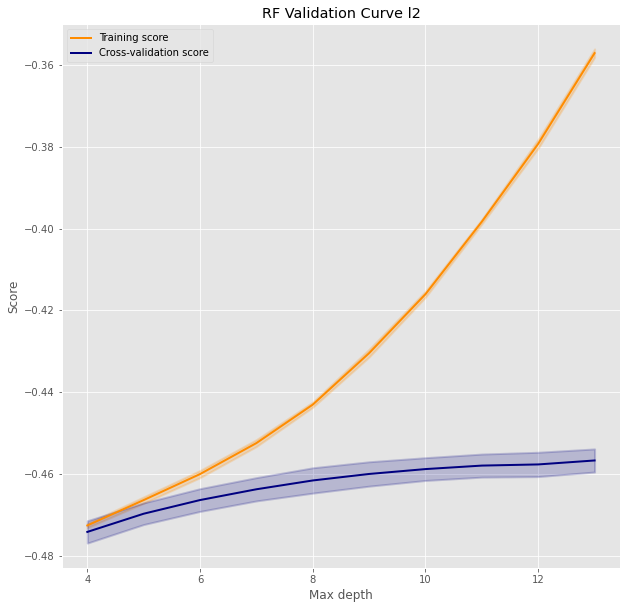

In [542]:
plot_validation_curve(train_scores, test_scores, 
                      'RF Validation Curve '+penalty, 
                      'Max depth', log=False)

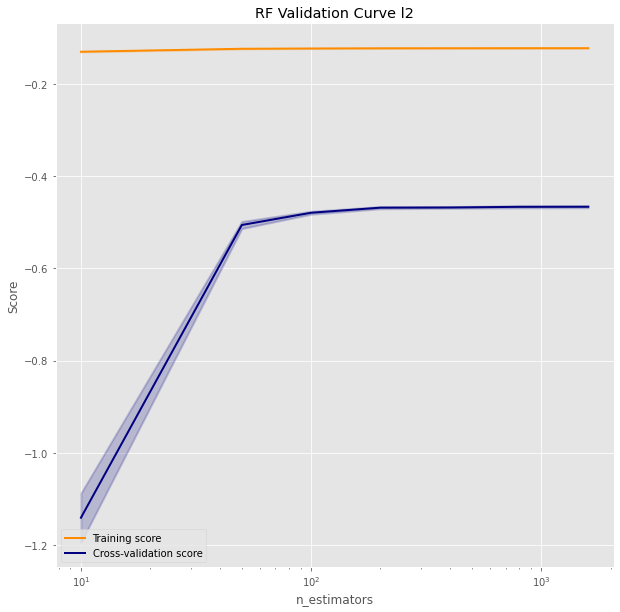

In [559]:
from sklearn.model_selection import StratifiedKFold, validation_curve 
from sklearn.pipeline import Pipeline

# instantiate preprocessor pipeline
preprocessor = make_preprocessor()

# instantiate cross-validation iterator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# generate a range of parameter values
param_range = [10, 50, 100, 200, 400, 800, 1600]

# make pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', RandomForestClassifier())  
])

# generate average cv train and test scores for each parameter 
# value in the param_range
train_scores, test_scores = validation_curve(
    pipe, X_train, y_train, param_name="estimator__n_estimators",
    param_range=param_range,scoring="neg_log_loss",
    cv=cv, n_jobs=-1)

# pass scores to a utility function that plots the curve
plot_validation_curve(train_scores, test_scores, 
                      'RF Validation Curve', 'n_estimators')

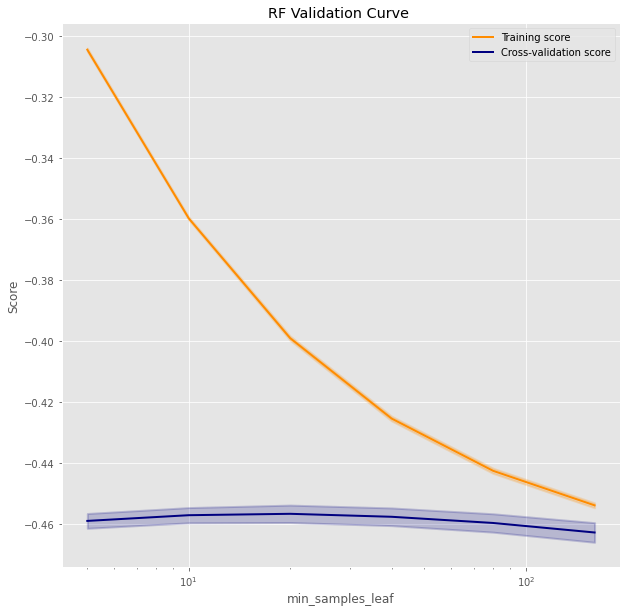

In [562]:
# instantiate transformers
preprocessor = make_preprocessor()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_range = [5, 10, 20, 40, 80, 160]

   
# make pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', RandomForestClassifier())  
])

train_scores, test_scores = validation_curve(
    pipe, X_train, y_train, param_name="estimator__min_samples_leaf", param_range=param_range,
    scoring="neg_log_loss", cv=cv, n_jobs=-1)

plot_validation_curve(train_scores, test_scores, 'RF Validation Curve ', 'min_samples_leaf')

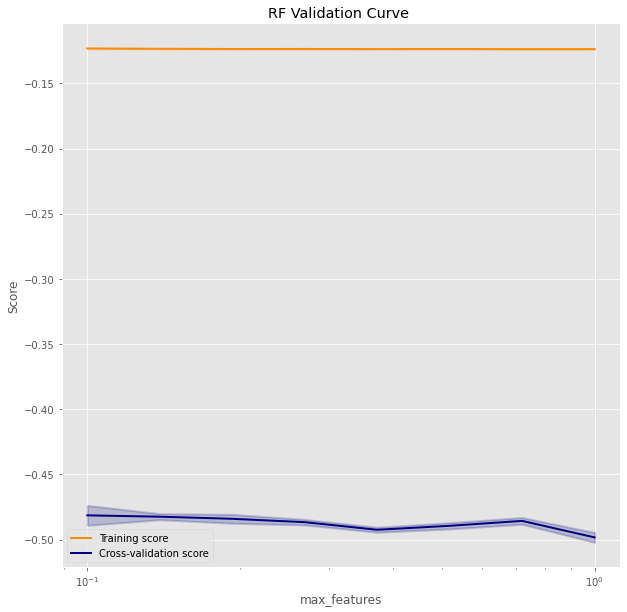

In [563]:
# instantiate transformers
preprocessor = make_preprocessor()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_range = np.logspace(-1, 0, 8)

   
# make pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', RandomForestClassifier())  
])

train_scores, test_scores = validation_curve(
    pipe, X_train, y_train, param_name="estimator__max_features", param_range=param_range,
    scoring="neg_log_loss", cv=cv, n_jobs=-1)

plot_validation_curve(train_scores, test_scores, 'RF Validation Curve ', 'max_features')

In [592]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as ss

# instantiate preprocesort
preprocessor = make_preprocessor()

# instantiate cross-validation iterator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# make pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', RandomForestClassifier())
])

# parameter grid to pass into random search cv
param_grid = {
    'estimator__min_samples_leaf': ss.randint(10,40),
    'estimator__n_estimators': ss.randint(50, 300),
    'estimator__max_depth': ss.randint(8,14),
    'estimator__max_features': ss.uniform(0.6,0.2)
}

# set no of parameter settings to be investigated randomly at 30
n_iter_search = 30

# instantiate the random search cv object
random_search_rf = RandomizedSearchCV(
    pipe, param_distributions=param_grid, 
    n_iter=n_iter_search, cv=cv,
    scoring='neg_log_loss', n_jobs=-1)

start = time()

# run randomized search by fitting to train data
random_search_rf.fit(X_train, y_train)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

# pass the results to utility function that reports the top results
report(random_search_rf.cv_results_)

RandomizedSearchCV took 5820.62 seconds for 30 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.457 (std: 0.003)
Parameters: {'estimator__max_depth': 13, 'estimator__max_features': 0.6271678330983383, 'estimator__min_samples_leaf': 20, 'estimator__n_estimators': 293}

Model with rank: 2
Mean validation score: -0.457 (std: 0.003)
Parameters: {'estimator__max_depth': 13, 'estimator__max_features': 0.6678147679562197, 'estimator__min_samples_leaf': 24, 'estimator__n_estimators': 197}

Model with rank: 3
Mean validation score: -0.457 (std: 0.003)
Parameters: {'estimator__max_depth': 13, 'estimator__max_features': 0.7998394653788398, 'estimator__min_samples_leaf': 22, 'estimator__n_estimators': 229}



## XGB

For the default XGB model, we observe that the training and validation learning curves are trending towards convergence. The model has slightly high bias and relatively low variance. Given that XGB is highly optimisable, parameters controlling the complexity were optimised, in hopes to increase complexity but control overfitting at the same time.

Parameters of interest are: n_estimators, min_child_weight, max_depth, and learning_rate.

[-0.59454113 -0.46756288 -0.46900734 -0.50237207 -0.54752389]


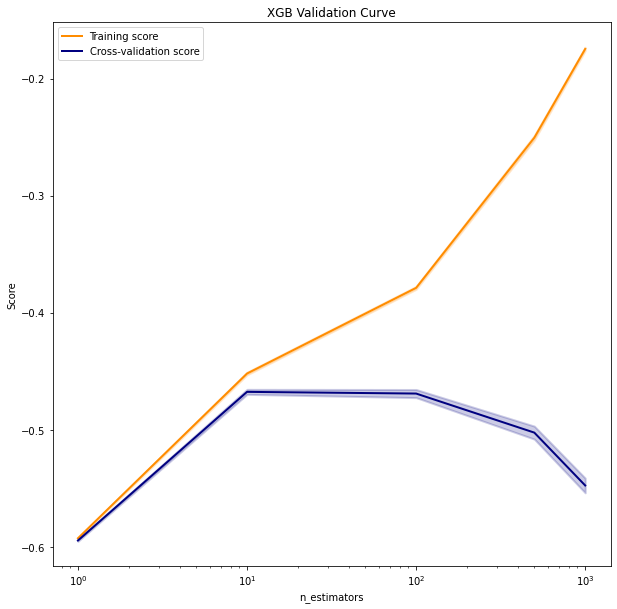

In [20]:
# instantiate transformers
preprocessor = make_preprocessor()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_range = [1, 10, 100, 500, 1000]

# make pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss'))  
])
  
train_scores, test_scores = validation_curve(
      pipe, X_train, y_train, param_name="estimator__n_estimators", param_range=param_range,
      scoring="neg_log_loss", cv=cv, n_jobs=-1)

print(np.mean(test_scores, axis=1))
plot_validation_curve(train_scores, test_scores, 'XGB Validation Curve', 'n_estimators', log=True)

We see that n_estimators in he range of 10s to 100s are appropriate.

[-0.4754119  -0.47205795 -0.46961493 -0.46576682 -0.46794781 -0.48035987]


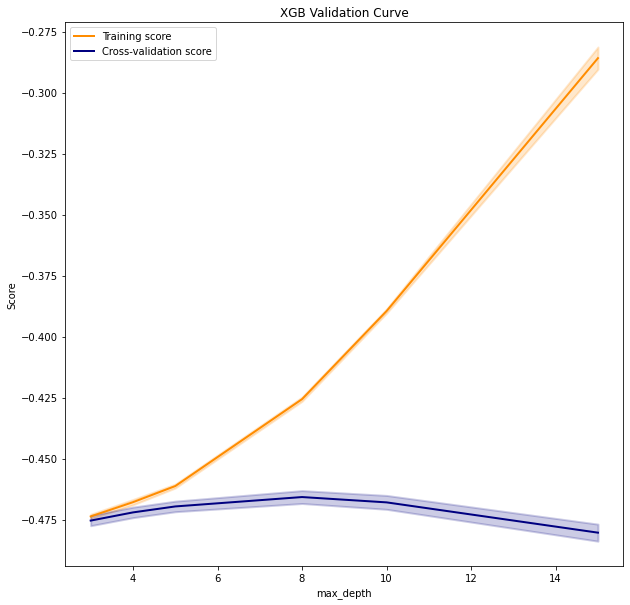

In [21]:
# instantiate transformers
preprocessor = make_preprocessor()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_range = [3, 4, 5, 8, 10, 15]

# make pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss',
                                n_estimators=10))  
])
  
train_scores, test_scores = validation_curve(
      pipe, X_train, y_train, param_name="estimator__max_depth", param_range=param_range,
      scoring="neg_log_loss", cv=cv, n_jobs=-1)

print(np.mean(test_scores, axis=1))
plot_validation_curve(train_scores, test_scores, 'XGB Validation Curve', 'max_depth', log=False)

Similarly, we see that max_depth of 4 to 9 would be appropriate

[-0.46576682 -0.46589266 -0.46557807 -0.46608812]


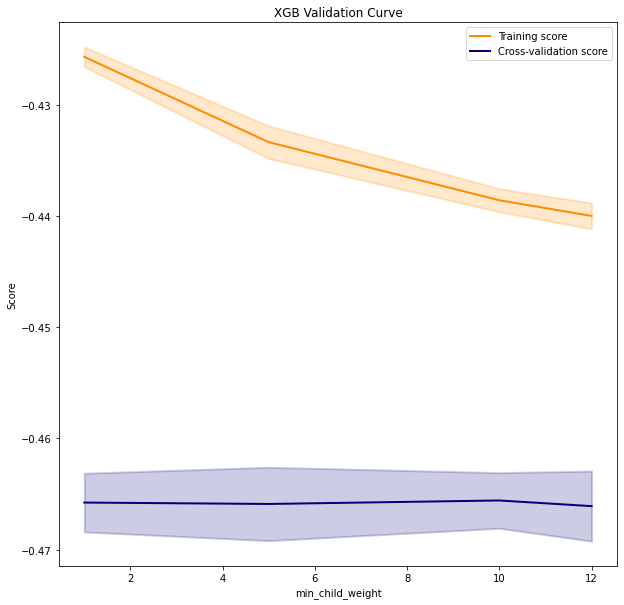

In [22]:
# instantiate transformers
preprocessor = make_preprocessor()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_range = [ 1, 5, 10, 12 ]

# make pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss',
                                n_estimators=10, max_depth=8))  
])
  
train_scores, test_scores = validation_curve(
      pipe, X_train, y_train, param_name="estimator__min_child_weight", param_range=param_range,
      scoring="neg_log_loss", cv=cv, n_jobs=-1)

print(np.mean(test_scores, axis=1))
plot_validation_curve(train_scores, test_scores, 'XGB Validation Curve', 'min_child_weight', log=False)

[-0.65744036 -0.63339326 -0.59784532 -0.55210198 -0.50584554 -0.4746983
 -0.46545272 -0.46821175]


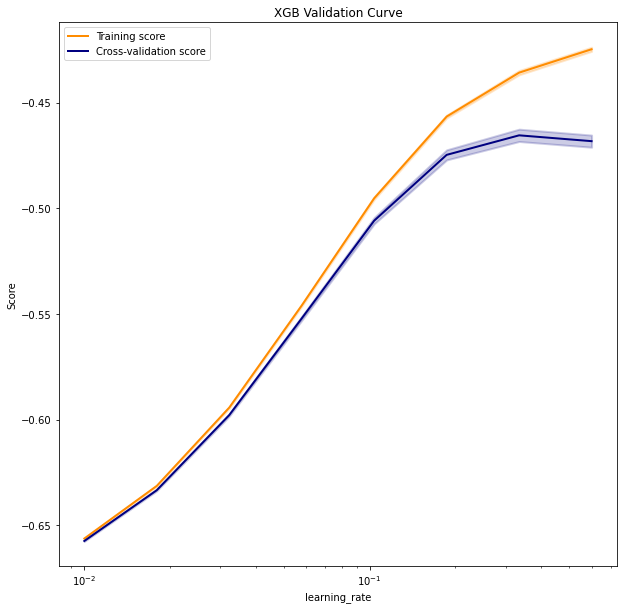

In [23]:
preprocessor = make_preprocessor()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_range = np.geomspace(0.01, 0.6, 8)

# make pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss',
                                n_estimators=10, max_depth=8, min_child_weight=10))  
])
  
train_scores, test_scores = validation_curve(
      pipe, X_train, y_train, param_name="estimator__learning_rate", param_range=param_range,
      scoring="neg_log_loss", cv=cv, n_jobs=-1)

print(np.mean(test_scores, axis=1))
plot_validation_curve(train_scores, test_scores, 'XGB Validation Curve', 'learning_rate', log=True)

In [24]:
# instantiate transformers
preprocessor = make_preprocessor()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# make pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss'))
])

# parameter grid to pass into randomsearch
param_grid = {
    'estimator__min_child_weight': ss.randint(5, 12), #
    'estimator__n_estimators': ss.randint(10, 150),
    'estimator__max_depth': ss.randint(4, 9),
    'estimator__learning_rate': ss.loguniform(0.18,0.6)
}

# run randomized search
n_iter_search = 30
random_search_xgb = RandomizedSearchCV(pipe, param_distributions=param_grid, n_iter=n_iter_search, cv=cv,
                                      scoring='neg_log_loss', n_jobs=-1)

start = time()
random_search_xgb.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))


RandomizedSearchCV took 2097.96 seconds for 30 candidates parameter settings.


NameError: name 'report' is not defined

In [28]:
report(random_search_xgb.cv_results_)

Model with rank: 1
Mean validation score: -0.461 (std: 0.003)
Parameters: {'estimator__learning_rate': 0.19986251143278685, 'estimator__max_depth': 4, 'estimator__min_child_weight': 9, 'estimator__n_estimators': 112}

Model with rank: 2
Mean validation score: -0.461 (std: 0.003)
Parameters: {'estimator__learning_rate': 0.1832521500711521, 'estimator__max_depth': 5, 'estimator__min_child_weight': 7, 'estimator__n_estimators': 70}

Model with rank: 3
Mean validation score: -0.462 (std: 0.003)
Parameters: {'estimator__learning_rate': 0.19083995475442925, 'estimator__max_depth': 5, 'estimator__min_child_weight': 7, 'estimator__n_estimators': 72}



## Tuned Performance

Evaluation of LR_tuned
Roc_auc avg score: 0.735, sd: 0.004
Neg_log_loss avg score: -0.473, sd: 0.002
Neg_brier_score avg score: -0.154, sd: 0.001
Balanced_accuracy avg score: 0.560, sd: 0.002
F1 avg score: 0.239, sd: 0.004
Recall avg score: 0.150, sd: 0.003
Precision avg score: 0.592, sd: 0.011


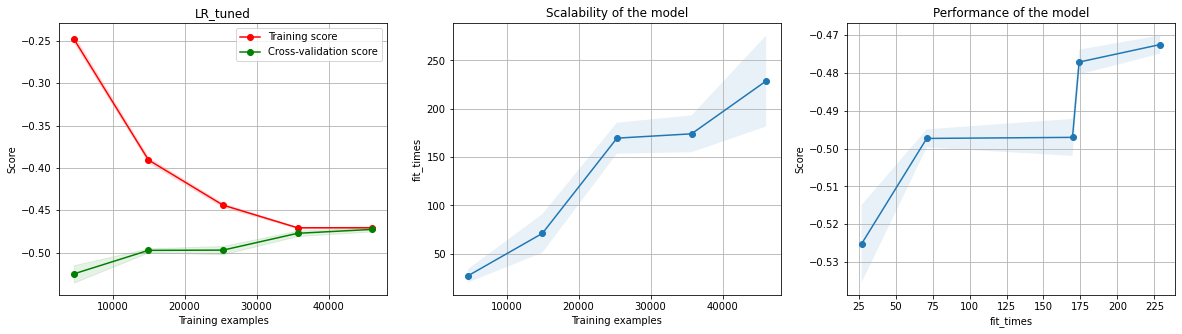

Evaluation of DT_tuned
Roc_auc avg score: 0.726, sd: 0.006
Neg_log_loss avg score: -0.477, sd: 0.003
Neg_brier_score avg score: -0.155, sd: 0.001
Balanced_accuracy avg score: 0.545, sd: 0.002
F1 avg score: 0.186, sd: 0.009
Recall avg score: 0.109, sd: 0.006
Precision avg score: 0.622, sd: 0.016


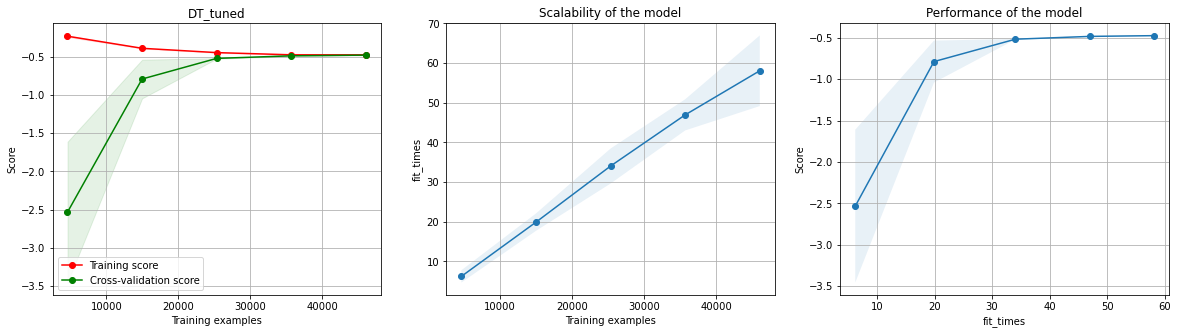

Evaluation of RF_tuned
Roc_auc avg score: 0.752, sd: 0.005
Neg_log_loss avg score: -0.462, sd: 0.003
Neg_brier_score avg score: -0.150, sd: 0.001
Balanced_accuracy avg score: 0.564, sd: 0.002
F1 avg score: 0.251, sd: 0.006
Recall avg score: 0.157, sd: 0.004
Precision avg score: 0.621, sd: 0.012


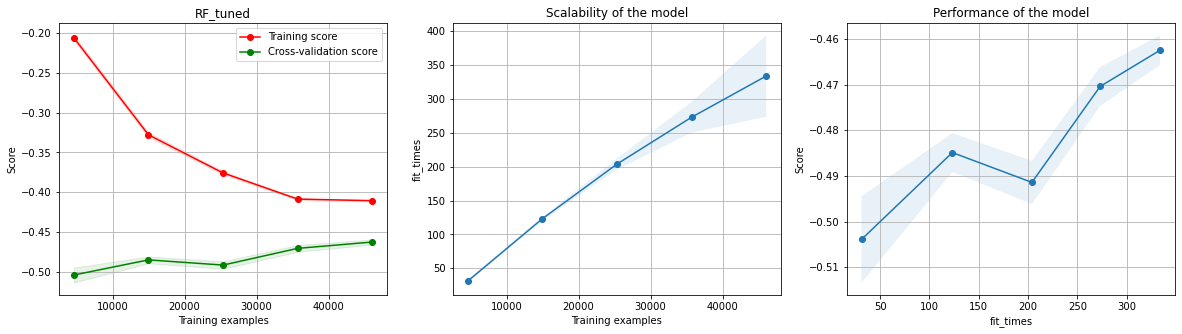

Evaluation of XGB_tuned
Roc_auc avg score: 0.754, sd: 0.005
Neg_log_loss avg score: -0.461, sd: 0.003
Neg_brier_score avg score: -0.149, sd: 0.001
Balanced_accuracy avg score: 0.571, sd: 0.002
F1 avg score: 0.271, sd: 0.006
Recall avg score: 0.174, sd: 0.006
Precision avg score: 0.617, sd: 0.013


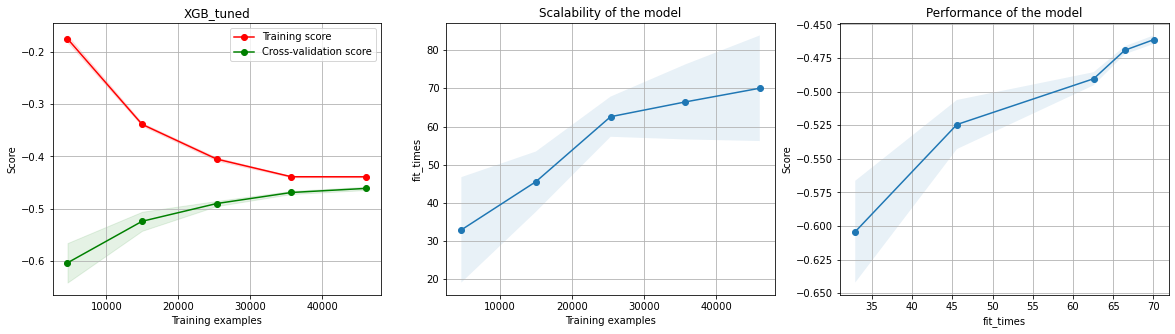

In [29]:
# instantiate transformers
preprocessor = make_preprocessor()
scaler = MinMaxScaler()

# instantiate estimators
lr = LogisticRegression(C=3.593813663804626, solver='saga',
                        penalty='l1', max_iter=1000)
dt = DecisionTreeClassifier(criterion='entropy', max_depth=6,
                            max_features=0.6218618170059151,
                            min_impurity_decrease=0.00029495461907492673)
rf = RandomForestClassifier(max_depth=13, max_features=0.6271678330983383,
                            min_samples_leaf=20, n_estimators=293)
xgb = XGBClassifier(objective='binary:logistic',
                    eval_metric='logloss', learning_rate=0.19986251143278685,
                    max_depth=4, min_child_weight=9, n_estimators=112,
                    use_label_encoder=False)

models = {'LR': lr, 'DT': dt, 'RF': rf, 'XGB': xgb}

# evaluate estimators in to_scale
for k, estimator in models.items():
    
    if k == 'LR':
    
        clf = Pipeline([
            ('preprocessor', preprocessor),
            ('scaler', scaler), # scale features
            ('estimator', estimator)]
        )
    
    else:
        clf = Pipeline([
            ('preprocessor', preprocessor),
            ('estimator', estimator)]
        )
    
    result = pd.concat([result, run_eval(clf, k +'_tuned')])
    
    
    # store model in model dict
    models_dict[k+'_tuned'] = clf
    
    # save model
    dump(clf, '../../Model/Models/'+k+'_tuned.joblib')

In [50]:
result

Roc_auc  Neg_log_loss  Neg_brier_score  \
NaiveClf_stratified       0.498       -12.084           -0.350   
NaiveClf_most_frequent    0.500        -7.861           -0.228   
NaiveClf_prior            0.500        -0.536           -0.176   
LR_default                0.735        -0.473           -0.154   
DT_default                0.580       -10.477           -0.304   
RF_default                0.730        -0.487           -0.155   
XGB_default               0.745        -0.469           -0.151   
LR_tuned                  0.735        -0.473           -0.154   
DT_tuned                  0.726        -0.477           -0.155   
RF_tuned                  0.752        -0.462           -0.150   
XGB_tuned                 0.754        -0.461           -0.149   

                        Balanced_accuracy     F1  Recall  Precision  
NaiveClf_stratified                 0.498  0.221   0.219      0.224  
NaiveClf_most_frequent              0.500  0.000   0.000      0.000  
NaiveClf_prior                      0.500  0.000   0.000      0.000  
LR_default                          0.558  0.235   0.147      0.593  
DT_default                          0.579  0.353   0.364      0.343  
RF_default                          0.579  0.303   0.211      0.538  
XGB_default                         0.583  0.309   0.211      0.578  
LR_tuned                            0.560  0.239   0.150      0.592  
DT_tuned                            0.545  0.186   0.109      0.622  
RF_tuned                            0.564  0.251   0.157      0.621  
XGB_tuned                           0.571  0.271   0.174      0.617

Overall, hyperparaemter tuning has improved the overall performances for all models, especially for the decision tree and random forest models. XGB model performance is still the best.

# Imbalance Treatment

Due to some compatibility issues with the processing pipeline in preprocessor and that of the imbalance-learn pipeline, we are unable to run the preprocessing step within the cross-validation cycle alongside sampling. As such, we will have to process the dataset first as a separate step before feeding the processed dataset into the pipeline with the sampler which can be run as a cross-validation.

We will a set of evauation of the models (tuned) with and without the sampler on the preprocessed dataset.

In [51]:
# make preprocessor
preprocessor1 = make_preprocessor()
# process X_train
X_train_proc = preprocessor1.fit_transform(X_train)
# proess X_test
X_test_proc = preprocessor1.transform(X_test)

## SMOTE & Random Under Sampling, SMOTEEN

In [53]:
# check imabalance
y_train.value_counts(normalize=True)

0    0.772401
1    0.227599
Name: defaulted, dtype: float64

In [54]:
0.772/0.228, 0.228/0.772

(3.3859649122807016, 0.29533678756476683)

We will try to reduce the imbalanced a little by reducing the majority: minority ratio to be about 2:1. We will employ both oversampling with some undersampling which have been said to be a better approach then just oversampling

In [55]:
# oversampling the minority. currently the ratio is 0.29, lets oversample to increase ratio to about 0.4 
over = SMOTE(sampling_strategy=0.4)

# undersample the majority to minorityL majority ratio of 0.5.
under = RandomUnderSampler(sampling_strategy=0.5)

Here, we will also explore usign SMOTEENN, which is an implementation of a combination of oversampling and undersampling.

Below, we evaluate the performances of the various strategies

In [57]:
# LR
lr_est = LogisticRegression(max_iter=1000)
# DT 
dt_est = DecisionTreeClassifier()
# rf
rf_est = RandomForestClassifier()
# xgb
xgb_est = XGBClassifier(objective='binary:logistic',
                        eval_metric='logloss', use_label_encoder=False)

estimators = {'LR_def': lr_est,
              'DT_def': dt_est,
              'RF_def': rf_est,
              'XGB_def': xgb_est}

for n, estimator in estimators.items():
    
    print('Evaluating '+n)

    # w/o smote pipe
    clf_vanilla = Pipeline_sampler([
        ('scaler', MinMaxScaler()),
        ('estimator', estimator)]
    )
    # evaluate w/o smote_rus
    result = pd.concat([result, run_eval(clf_vanilla, n+'_vanilla', X_train_proc, y_train, draw=False)])
   
    # store model in model dict
    models_dict[n+'_vanilla'] = clf_vanilla
    
    # save model
    dump(clf_vanilla, '../../Model/Models/'+n+'_vanilla.joblib')
    
    print('')
    
    # w smote_rus pipe
    clf_smote_rus = Pipeline_sampler([
        ('scaler', MinMaxScaler()),
        ('oversampler', over),
        ('undersampler', under),
        ('estimator', estimator)]
    )

    # evaluate w smote_rus
    result = pd.concat([result, run_eval(clf_smote_rus, n+'_smote_rus', X_train_proc, y_train, draw=False)])
    
    # store model in model dict
    models_dict[n+'_smote_rus'] = clf_smote_rus
    
    # save model
    dump(clf_smote_rus, '../../Model/Models/'+n+'_smote_rus.joblib')
    
    print('')
    
    # w smoteenn pipe
    clf_smoteenn = Pipeline_sampler([
        ('scaler', MinMaxScaler()),
        ('sampler', SMOTEENN()),
        ('estimator', estimator)]
    )
    # evaluate w smote_rus
    result = pd.concat([result, run_eval(clf_smoteenn, n+'_smoteenn', X_train_proc, y_train, draw=False)])
    
    # store model in model dict
    models_dict[n+'_smoteenn'] = clf_smoteenn
    
    # save model
    dump(clf_smoteenn, '../../Model/Models/'+n+'_smoteenn.joblib')
    
    print('')

Evaluating LR_def
Evaluation of LR_def_vanilla
Roc_auc avg score: 0.735, sd: 0.004
Neg_log_loss avg score: -0.473, sd: 0.003
Neg_brier_score avg score: -0.154, sd: 0.001
Balanced_accuracy avg score: 0.558, sd: 0.002
F1 avg score: 0.235, sd: 0.006
Recall avg score: 0.146, sd: 0.004
Precision avg score: 0.593, sd: 0.014

Evaluation of LR_def_smote_rus
Roc_auc avg score: 0.735, sd: 0.004
Neg_log_loss avg score: -0.496, sd: 0.003
Neg_brier_score avg score: -0.163, sd: 0.001
Balanced_accuracy avg score: 0.631, sd: 0.004
F1 avg score: 0.428, sd: 0.007
Recall avg score: 0.394, sd: 0.010
Precision avg score: 0.468, sd: 0.007

Evaluation of LR_def_smoteenn
Roc_auc avg score: 0.732, sd: 0.004
Neg_log_loss avg score: -0.855, sd: 0.009
Neg_brier_score avg score: -0.291, sd: 0.003
Balanced_accuracy avg score: 0.660, sd: 0.005
F1 avg score: 0.466, sd: 0.004
Recall avg score: 0.817, sd: 0.004
Precision avg score: 0.326, sd: 0.004

Evaluating DT_def
Evaluation of DT_def_vanilla
Roc_auc avg score: 0.58

In [58]:
result

Roc_auc  Neg_log_loss  Neg_brier_score  \
NaiveClf_stratified       0.498       -12.084           -0.350   
NaiveClf_most_frequent    0.500        -7.861           -0.228   
NaiveClf_prior            0.500        -0.536           -0.176   
LR_default                0.735        -0.473           -0.154   
DT_default                0.580       -10.477           -0.304   
RF_default                0.730        -0.487           -0.155   
XGB_default               0.745        -0.469           -0.151   
LR_tuned                  0.735        -0.473           -0.154   
DT_tuned                  0.726        -0.477           -0.155   
RF_tuned                  0.752        -0.462           -0.150   
XGB_tuned                 0.754        -0.461           -0.149   
LR_defdefault_vanilla     0.735        -0.473           -0.154   
LR_def_vanilla            0.735        -0.473           -0.154   
LR_def_smote_rus          0.735        -0.496           -0.163   
LR_def_smoteenn           0.732        -0.855           -0.291   
DT_def_vanilla            0.581       -10.455           -0.303   
DT_def_smote_rus          0.586       -11.025           -0.319   
DT_def_smoteenn           0.632       -11.874           -0.344   
RF_def_vanilla            0.731        -0.486           -0.155   
RF_def_smote_rus          0.732        -0.492           -0.160   
RF_def_smoteenn           0.740        -0.762           -0.213   
XGB_def_vanilla           0.746        -0.469           -0.151   
XGB_def_smote_rus         0.748        -0.473           -0.154   
XGB_def_smoteenn          0.744        -0.618           -0.202   

                        Balanced_accuracy     F1  Recall  Precision  
NaiveClf_stratified                 0.498  0.221   0.219      0.224  
NaiveClf_most_frequent              0.500  0.000   0.000      0.000  
NaiveClf_prior                      0.500  0.000   0.000      0.000  
LR_default                          0.558  0.235   0.147      0.593  
DT_default                          0.579  0.353   0.364      0.343  
RF_default                          0.579  0.303   0.211      0.538  
XGB_default                         0.583  0.309   0.211      0.578  
LR_tuned                            0.560  0.239   0.150      0.592  
DT_tuned                            0.545  0.186   0.109      0.622  
RF_tuned                            0.564  0.251   0.157      0.621  
XGB_tuned                           0.571  0.271   0.174      0.617  
LR_defdefault_vanilla               0.558  0.235   0.146      0.593  
LR_def_vanilla                      0.558  0.235   0.146      0.593  
LR_def_smote_rus                    0.631  0.428   0.394      0.468  
LR_def_smoteenn                     0.660  0.466   0.817      0.326  
DT_def_vanilla                      0.580  0.355   0.366      0.344  
DT_def_smote_rus                    0.586  0.370   0.412      0.336  
DT_def_smoteenn                     0.632  0.438   0.588      0.349  
RF_def_vanilla                      0.580  0.305   0.212      0.544  
RF_def_smote_rus                    0.609  0.384   0.318      0.484  
RF_def_smoteenn                     0.677  0.489   0.649      0.393  
XGB_def_vanilla                     0.582  0.308   0.210      0.579  
XGB_def_smote_rus                   0.616  0.396   0.324      0.510  
XGB_def_smoteenn                    0.678  0.493   0.614      0.412

When compared to the similarly processed vanilla models, the probabilistic estimation performance of the models does not seem to improve, but diminishes instead as evident from the poorer neg. log loss and Brier score metrics of the SMOTEENN and SMOTE-RUS models. ROC AUC seems to improve for the RF and DT models with under and oversampling and this is because these default models tend to overfit the training data and may have learnt to over predict a particular target class label which could theoretically improve ROC AUC, but in reality, provides a poor probability estimate as indicated by the porter log loss and Brier score.

# Probability Calibration

Probability calibration was carried out on the four tuned classification models. The intent is to allow for the model to provide a better probability estimation.
Reliability plots of the probabilistic predictions before and after calibration were made to compare how well the calibrations were, and the calibrated models were also evaluated on the training dataset to provide a comparison.

## Uncalibrated Plots

C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


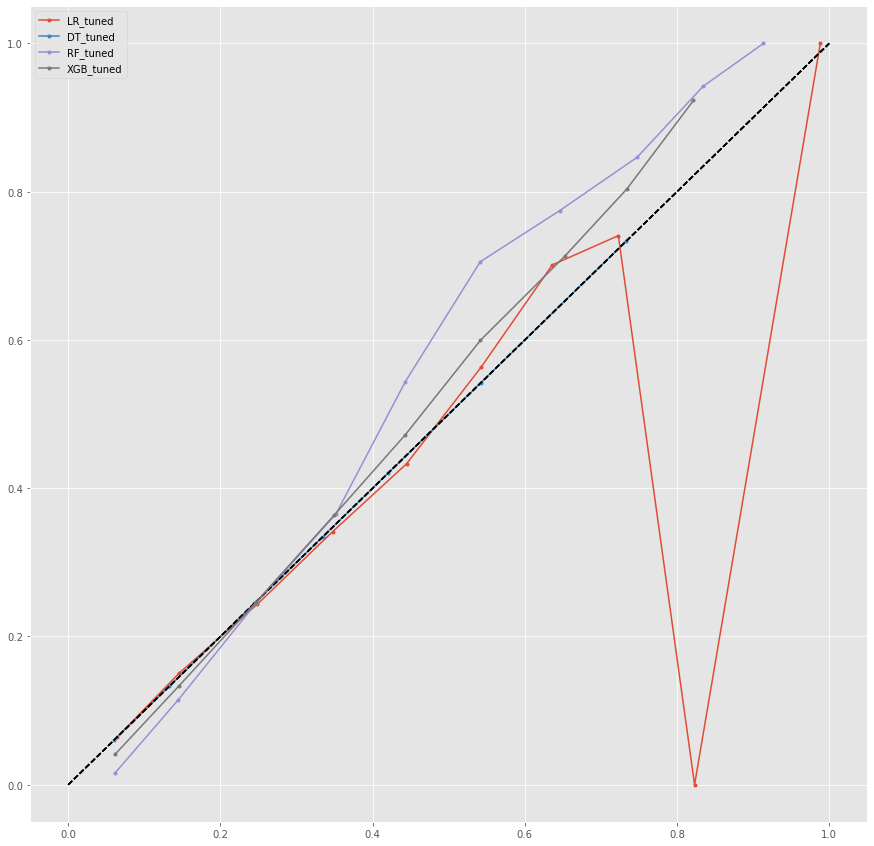

In [66]:
# plot on same axes
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15,15))

# plot uncalibrated tuned models
for name, model in models_dict.items():
    if search("_tuned\Z", name):
        model.fit(X_train,y_train)
            
        # save model
        dump(model, '../../Model/Models/'+name+'_fitted.joblib')
        
        ax = plot_reliability_curves(model, name, ax, X_train, y_train)

plt.legend()
plt.show()

## Calibration

In [67]:
# instantiate variables
preprocessor = make_preprocessor()
scaler = MinMaxScaler()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2 methods of calibration
methods = ['sigmoid', 'isotonic']

In [68]:
# LR
lr_est = LogisticRegression(C=3.593813663804626, solver='saga',
                               penalty='l1', max_iter=1000)
# DT 
dt_est = DecisionTreeClassifier(criterion='entropy', max_depth=6,
                                max_features=0.6218618170059151,
                                min_impurity_decrease=0.00029495461907492673)

# rf
rf_est = RandomForestClassifier(max_depth=13, max_features=0.6271678330983383,
                                min_samples_leaf=20, n_estimators=293)

# XGB
xgb_est = XGBClassifier(objective='binary:logistic',
                        eval_metric='logloss', learning_rate=0.19986251143278685,
                        max_depth=4, min_child_weight=9, n_estimators=112,
                        use_label_encoder=False)

estimators = {'LR_tuned': lr_est,
              'DT_tuned': dt_est,
              'RF_tuned': rf_est,
              'XGB_tuned': xgb_est}

for method in methods:
    for n, estimator in estimators.items():
        # scale for LR
        if n == 'LR_tuned':
            clf = Pipeline([
                ('preprocessor', preprocessor),
                ('scaler', scaler),
                ('estimator', CalibratedClassifierCV(base_estimator=estimator,
                                                     method=method, cv=cv))]
            )
        else:
            clf = Pipeline([
                ('preprocessor', preprocessor),
                ('estimator', CalibratedClassifierCV(base_estimator=estimator,
                                                     method=method, cv=cv))]
            )
        
        print('Calibrating '+n+'_'+method)
        # calibrate model
        clf.fit(X_train,y_train)
        
        # store model
        models_dict[n+'_'+method] = clf
        
        # Save models
        dump(clf, n+'_'+method+'.joblib')

Calibrating LR_tuned_sigmoid


C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Calibrating DT_tuned_sigmoid
Calibrating RF_tuned_sigmoid
Calibrating XGB_tuned_sigmoid
Calibrating LR_tuned_isotonic


C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Calibrating DT_tuned_isotonic
Calibrating RF_tuned_isotonic
Calibrating XGB_tuned_isotonic


### Calibrated Plots

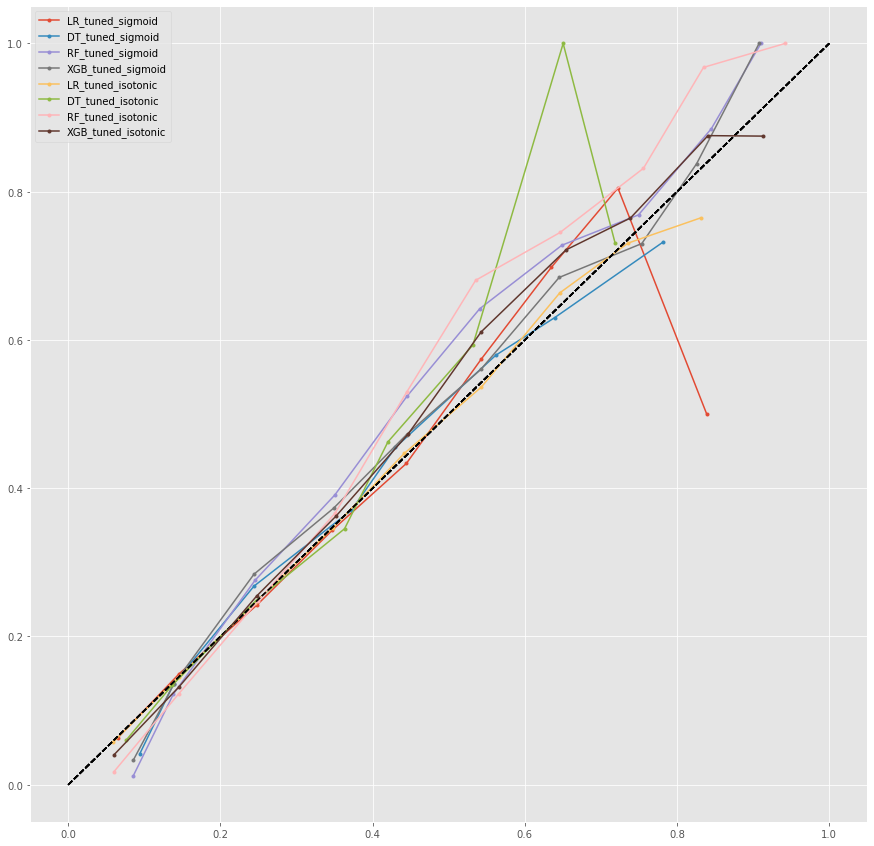

In [69]:
# plot calibration curve
from cycler import cycler
plt.style.use('ggplot')

# set colors
plt.rcParams['axes.prop_cycle'] = cycler('color', ['#E24A33','#348ABD','#988ED5',
                                                   '#777777','#FBC15E','#8EBA42',
                                                   '#FFB5B8', '#60372E'])
fig, ax = plt.subplots(figsize=(15,15))
 
# plot uncalibrated tuned models
for name, model in models_dict.items():
    if search("_tuned_(si|iso)", name):
    
        ax = plot_reliability_curves(model, name, ax,  X_train, y_train)

plt.legend()
plt.show()

### Performance

Run evaluation on the calibrated models.

Evaluation of LR_tuned_sigmoid
Roc_auc avg score: 0.735, sd: 0.004
Neg_log_loss avg score: -0.473, sd: 0.002
Neg_brier_score avg score: -0.154, sd: 0.001
Balanced_accuracy avg score: 0.556, sd: 0.002
F1 avg score: 0.228, sd: 0.006
Recall avg score: 0.141, sd: 0.004
Precision avg score: 0.595, sd: 0.012


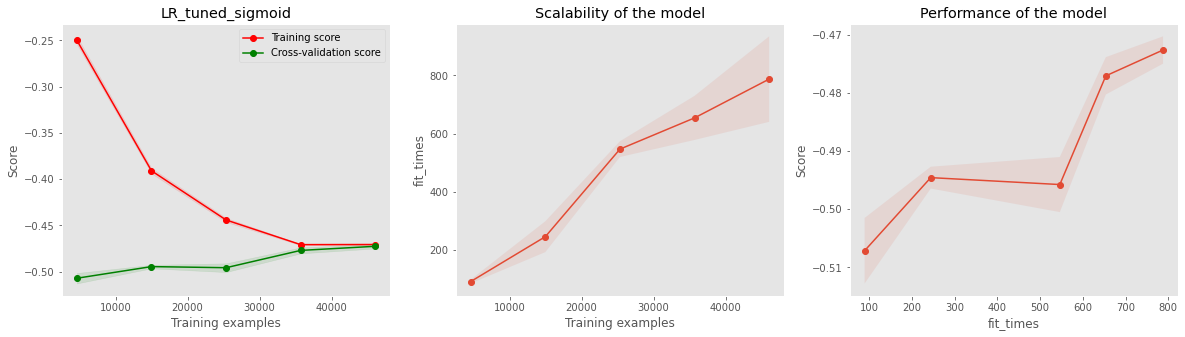

Evaluation of DT_tuned_sigmoid
Roc_auc avg score: 0.734, sd: 0.005
Neg_log_loss avg score: -0.476, sd: 0.003
Neg_brier_score avg score: -0.154, sd: 0.001
Balanced_accuracy avg score: 0.547, sd: 0.002
F1 avg score: 0.192, sd: 0.009
Recall avg score: 0.113, sd: 0.007
Precision avg score: 0.633, sd: 0.026


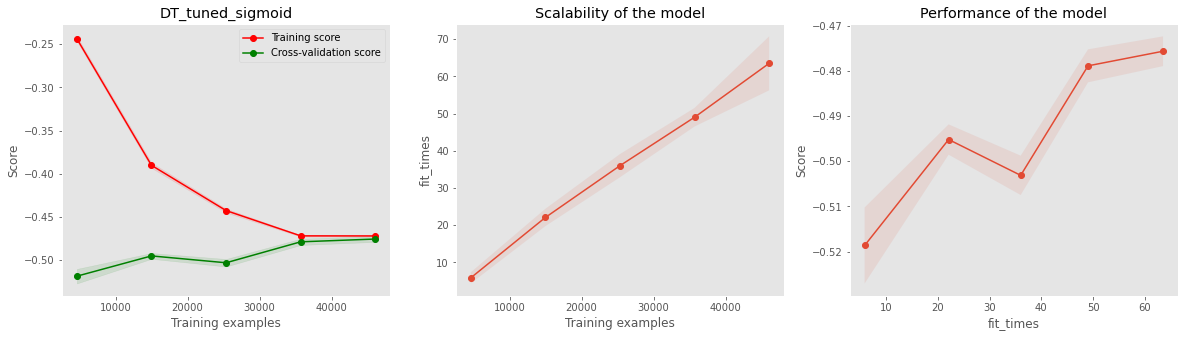

Evaluation of RF_tuned_sigmoid
Roc_auc avg score: 0.752, sd: 0.005
Neg_log_loss avg score: -0.466, sd: 0.003
Neg_brier_score avg score: -0.150, sd: 0.001
Balanced_accuracy avg score: 0.574, sd: 0.004
F1 avg score: 0.283, sd: 0.009
Recall avg score: 0.185, sd: 0.007
Precision avg score: 0.601, sd: 0.014


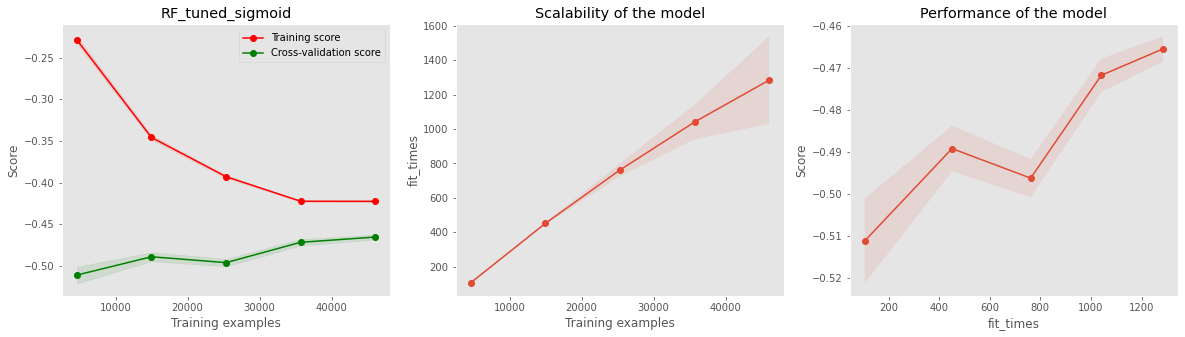

Evaluation of XGB_tuned_sigmoid
Roc_auc avg score: 0.755, sd: 0.005
Neg_log_loss avg score: -0.464, sd: 0.003
Neg_brier_score avg score: -0.150, sd: 0.001
Balanced_accuracy avg score: 0.578, sd: 0.003
F1 avg score: 0.294, sd: 0.007
Recall avg score: 0.195, sd: 0.005
Precision avg score: 0.597, sd: 0.016


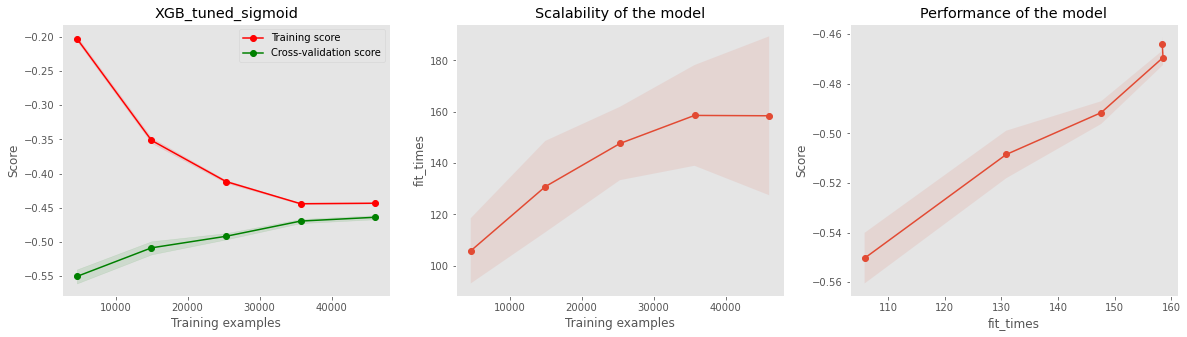

Evaluation of LR_tuned_isotonic
Roc_auc avg score: 0.735, sd: 0.004
Neg_log_loss avg score: -0.473, sd: 0.002
Neg_brier_score avg score: -0.154, sd: 0.001
Balanced_accuracy avg score: 0.556, sd: 0.002
F1 avg score: 0.226, sd: 0.007
Recall avg score: 0.139, sd: 0.005
Precision avg score: 0.594, sd: 0.013


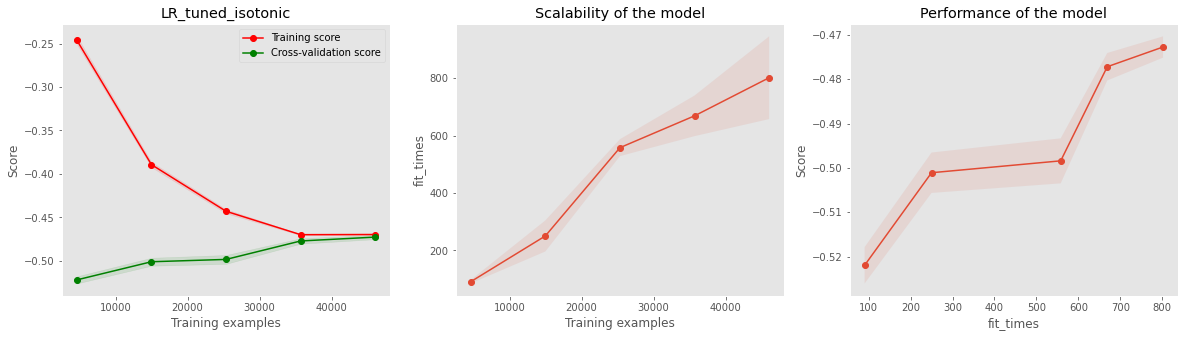

Evaluation of DT_tuned_isotonic
Roc_auc avg score: 0.734, sd: 0.006
Neg_log_loss avg score: -0.474, sd: 0.003
Neg_brier_score avg score: -0.154, sd: 0.001
Balanced_accuracy avg score: 0.542, sd: 0.003
F1 avg score: 0.171, sd: 0.011
Recall avg score: 0.098, sd: 0.008
Precision avg score: 0.661, sd: 0.037


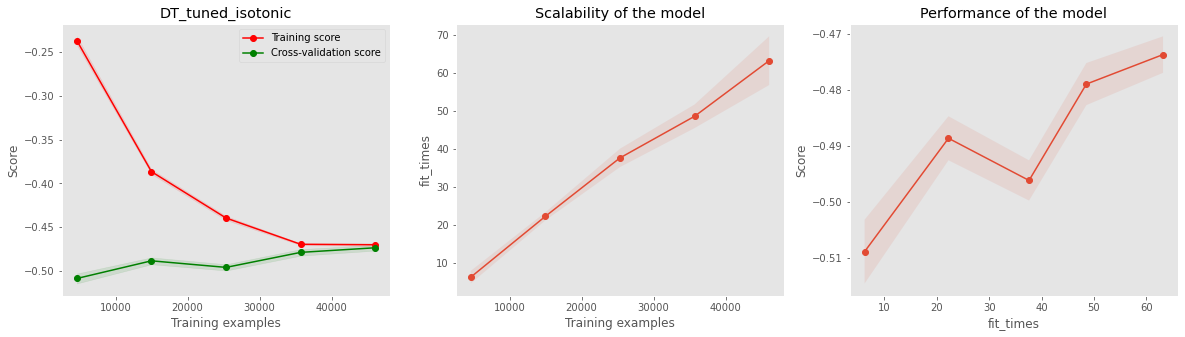

Evaluation of RF_tuned_isotonic
Roc_auc avg score: 0.752, sd: 0.005
Neg_log_loss avg score: -0.463, sd: 0.003
Neg_brier_score avg score: -0.150, sd: 0.001
Balanced_accuracy avg score: 0.566, sd: 0.003
F1 avg score: 0.256, sd: 0.009
Recall avg score: 0.162, sd: 0.008
Precision avg score: 0.619, sd: 0.017


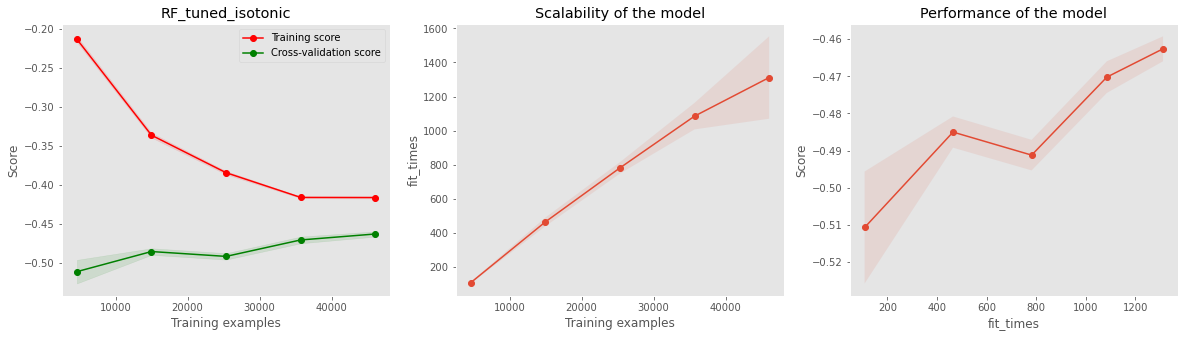

Evaluation of XGB_tuned_isotonic
Roc_auc avg score: 0.755, sd: 0.005
Neg_log_loss avg score: -0.461, sd: 0.004
Neg_brier_score avg score: -0.149, sd: 0.001
Balanced_accuracy avg score: 0.569, sd: 0.003
F1 avg score: 0.264, sd: 0.010
Recall avg score: 0.168, sd: 0.009
Precision avg score: 0.618, sd: 0.021


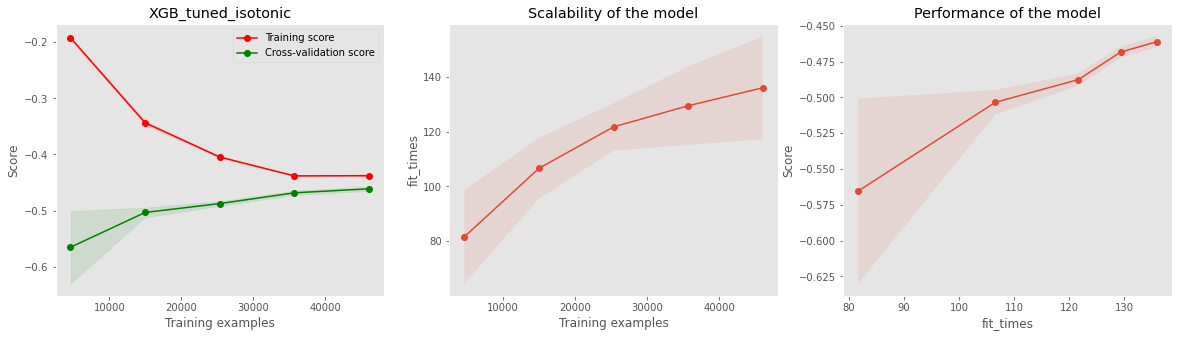

In [70]:
# run_evaluation
for name, model in models_dict.items():
    
    if search("_tuned_(si|iso)", name):
    
        result = pd.concat([result, run_eval(model, name, draw=True)]) # dont draw
        

In [72]:
pd.set_option('display.max_rows', None)
result

Roc_auc  Neg_log_loss  Neg_brier_score  \
NaiveClf_stratified       0.498       -12.084           -0.350   
NaiveClf_most_frequent    0.500        -7.861           -0.228   
NaiveClf_prior            0.500        -0.536           -0.176   
LR_default                0.735        -0.473           -0.154   
DT_default                0.580       -10.477           -0.304   
RF_default                0.730        -0.487           -0.155   
XGB_default               0.745        -0.469           -0.151   
LR_tuned                  0.735        -0.473           -0.154   
DT_tuned                  0.726        -0.477           -0.155   
RF_tuned                  0.752        -0.462           -0.150   
XGB_tuned                 0.754        -0.461           -0.149   
LR_defdefault_vanilla     0.735        -0.473           -0.154   
LR_def_vanilla            0.735        -0.473           -0.154   
LR_def_smote_rus          0.735        -0.496           -0.163   
LR_def_smoteenn           0.732        -0.855           -0.291   
DT_def_vanilla            0.581       -10.455           -0.303   
DT_def_smote_rus          0.586       -11.025           -0.319   
DT_def_smoteenn           0.632       -11.874           -0.344   
RF_def_vanilla            0.731        -0.486           -0.155   
RF_def_smote_rus          0.732        -0.492           -0.160   
RF_def_smoteenn           0.740        -0.762           -0.213   
XGB_def_vanilla           0.746        -0.469           -0.151   
XGB_def_smote_rus         0.748        -0.473           -0.154   
XGB_def_smoteenn          0.744        -0.618           -0.202   
LR_tuned_sigmoid          0.735        -0.473           -0.154   
DT_tuned_sigmoid          0.734        -0.476           -0.154   
RF_tuned_sigmoid          0.752        -0.466           -0.150   
XGB_tuned_sigmoid         0.755        -0.464           -0.150   
LR_tuned_isotonic         0.735        -0.473           -0.154   
DT_tuned_isotonic         0.734        -0.474           -0.154   
RF_tuned_isotonic         0.752        -0.463           -0.150   
XGB_tuned_isotonic        0.755        -0.461           -0.149   

                        Balanced_accuracy     F1  Recall  Precision  
NaiveClf_stratified                 0.498  0.221   0.219      0.224  
NaiveClf_most_frequent              0.500  0.000   0.000      0.000  
NaiveClf_prior                      0.500  0.000   0.000      0.000  
LR_default                          0.558  0.235   0.147      0.593  
DT_default                          0.579  0.353   0.364      0.343  
RF_default                          0.579  0.303   0.211      0.538  
XGB_default                         0.583  0.309   0.211      0.578  
LR_tuned                            0.560  0.239   0.150      0.592  
DT_tuned                            0.545  0.186   0.109      0.622  
RF_tuned                            0.564  0.251   0.157      0.621  
XGB_tuned                           0.571  0.271   0.174      0.617  
LR_defdefault_vanilla               0.558  0.235   0.146      0.593  
LR_def_vanilla                      0.558  0.235   0.146      0.593  
LR_def_smote_rus                    0.631  0.428   0.394      0.468  
LR_def_smoteenn                     0.660  0.466   0.817      0.326  
DT_def_vanilla                      0.580  0.355   0.366      0.344  
DT_def_smote_rus                    0.586  0.370   0.412      0.336  
DT_def_smoteenn                     0.632  0.438   0.588      0.349  
RF_def_vanilla                      0.580  0.305   0.212      0.544  
RF_def_smote_rus                    0.609  0.384   0.318      0.484  
RF_def_smoteenn                     0.677  0.489   0.649      0.393  
XGB_def_vanilla                     0.582  0.308   0.210      0.579  
XGB_def_smote_rus                   0.616  0.396   0.324      0.510  
XGB_def_smoteenn                    0.678  0.493   0.614      0.412  
LR_tuned_sigmoid                    0.556  0.228   0.141      0.595  
DT_tuned_sigmoid         

# Model Evaluation

## Threshold Optimisation

Carry out probability threshold optimisation to maximise G-means of sensitivity and specificity as a base. Using earlier defined utility function, find the appropriate threshold probability to set the various models at for evaluation.

We will be evaluating the tuned and the calibrated models as they showed the best results so far.

fitting NaiveClf_stratified
optimise NaiveClf_stratified
Best Threshold=1.000000, G-Mean=0.420


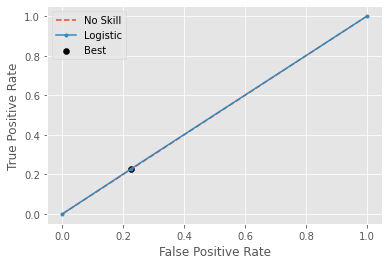

fitting NaiveClf_most_frequent
optimise NaiveClf_most_frequent
Best Threshold=1.000000, G-Mean=0.000


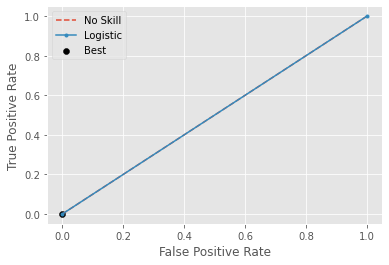

fitting NaiveClf_prior
optimise NaiveClf_prior
Best Threshold=1.227599, G-Mean=0.000


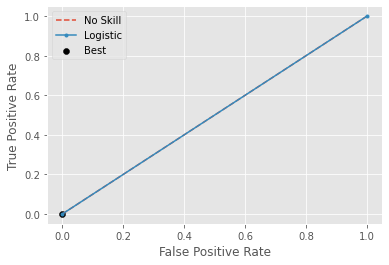

fitting LR_tuned


C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


optimise LR_tuned
Best Threshold=0.233704, G-Mean=0.675


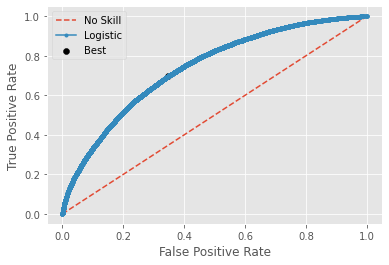

fitting DT_tuned
optimise DT_tuned
Best Threshold=0.230462, G-Mean=0.673


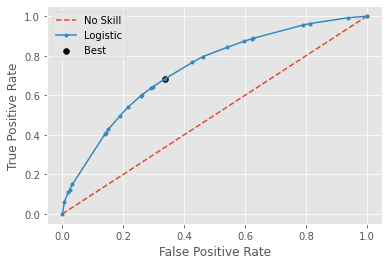

fitting RF_tuned
optimise RF_tuned
Best Threshold=0.243358, G-Mean=0.748


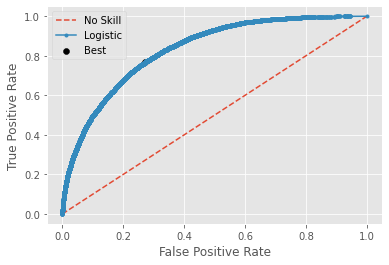

fitting XGB_tuned
optimise XGB_tuned
Best Threshold=0.235617, G-Mean=0.712


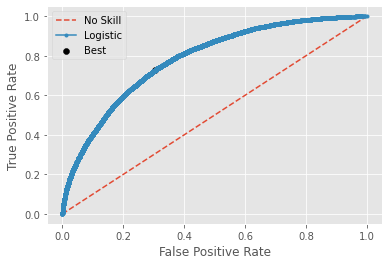

fitting LR_tuned_sigmoid


C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


optimise LR_tuned_sigmoid
Best Threshold=0.232928, G-Mean=0.675


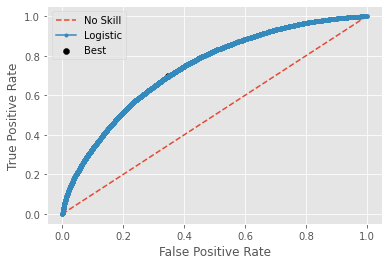

fitting DT_tuned_sigmoid
optimise DT_tuned_sigmoid
Best Threshold=0.192696, G-Mean=0.676


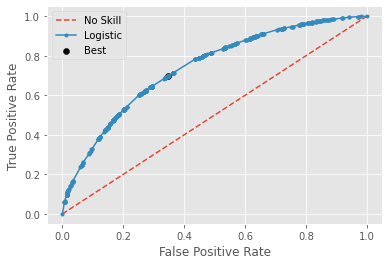

fitting RF_tuned_sigmoid
optimise RF_tuned_sigmoid
Best Threshold=0.211020, G-Mean=0.741


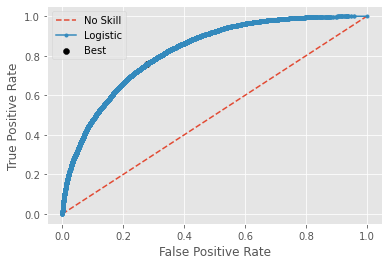

fitting XGB_tuned_sigmoid
optimise XGB_tuned_sigmoid
Best Threshold=0.209991, G-Mean=0.715


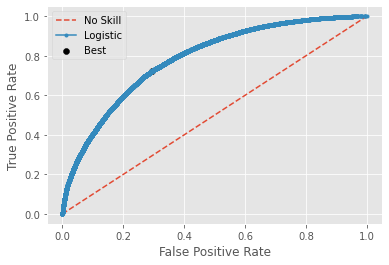

fitting LR_tuned_isotonic


C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


optimise LR_tuned_isotonic
Best Threshold=0.239205, G-Mean=0.675


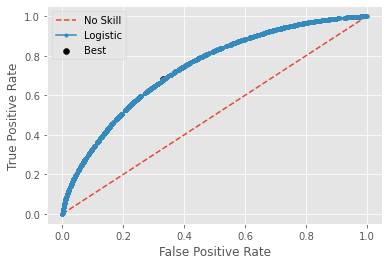

fitting DT_tuned_isotonic
optimise DT_tuned_isotonic
Best Threshold=0.228227, G-Mean=0.677


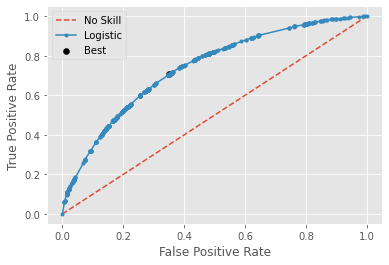

fitting RF_tuned_isotonic
optimise RF_tuned_isotonic
Best Threshold=0.246162, G-Mean=0.742


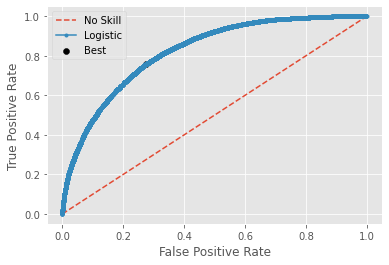

fitting XGB_tuned_isotonic
optimise XGB_tuned_isotonic
Best Threshold=0.241860, G-Mean=0.714


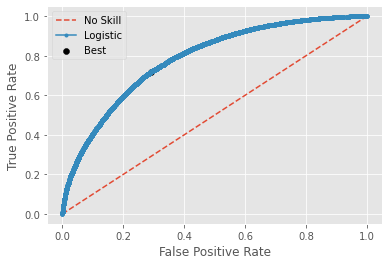

In [95]:
# temp_dict for fitted 
temp_dict={}

# model optimisation
for n, model in models_dict.items():
    if not search("_def_|smote|fitted|Default", n):
        
        # fit model
        print('fitting ' + n)
        model.fit(X_train, y_train)
        
        # store model
        temp_dict[n+'_fitted'] = model
        
        
        # optimise model
        print('optimise '+n)
        optimise(model, X_train, y_train)

# update models_dict
models_dict.update(temp_dict)

For naive classifiers, there are no appropriate thresholds due to their nature and evaluation will be ran on the default model settings.

## Evaluation

Evaluating LR_tuned_fittedtest
              precision    recall  f1-score   support

           0      0.938     0.636     0.758     12598
           1      0.216     0.705     0.331      1796

    accuracy                          0.644     14394
   macro avg      0.577     0.670     0.544     14394
weighted avg      0.848     0.644     0.704     14394

[[8007 4591]
 [ 530 1266]]
Evaluating DT_tuned_fittedtest
              precision    recall  f1-score   support

           0      0.910     0.796     0.849     12598
           1      0.239     0.449     0.312      1796

    accuracy                          0.752     14394
   macro avg      0.574     0.622     0.580     14394
weighted avg      0.826     0.752     0.782     14394

[[10022  2576]
 [  989   807]]
Evaluating NaiveClf_stratified_fittedtest
              precision    recall  f1-score   support

           0      0.875     0.775     0.822     12598
           1      0.124     0.223     0.159      1796

    accuracy        

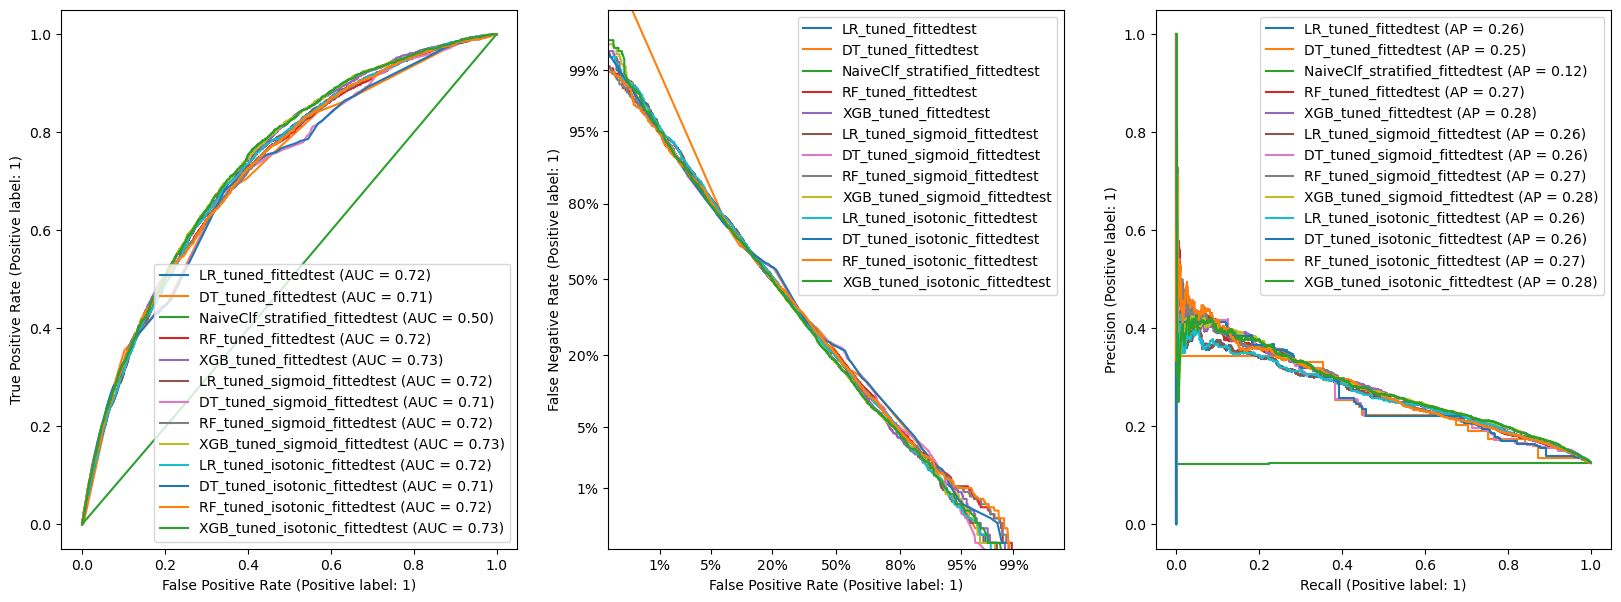

In [101]:
# evaluation test with optimisation
plt.style.use('default')
fig, (ax1, ax2, ax3) = plt.subplots(1 , 3, figsize=(20, 7))

eval_result = pd.DataFrame()

for name, model in models_dict.items():
    if not search('_most_frequent|_prior', name) and search('_fitted', name):
        if name == 'LR_tuned_fitted':
            thres = 0.233704
        elif name == 'LR_tuned_sigmoid_fitted':
            thres = 0.232928
        elif name == 'LR_tuned_isotonic_fitted':
            thres = 0.239205
        elif name == 'DT_tuned_fitted':
            thres = 0.230462
        elif name == 'DT_tuned_sigmoid_fitted':
            thres = 0.192696
        elif name == 'DT_tuned_isotonic_fitted':
            thres = 0.228227
        elif name == 'RF_tuned_fitted':
            thres = 0.243358
        elif name == 'RF_tuned_sigmoid_fitted':
            thres = 0.211020
        elif name == 'RF_tuned_isotonic_fitted':
            thres = 0.246162
        elif name == 'XGB_tuned_fitted':
            thres = 0.235617
        elif name == 'XGB_tuned_sigmoid_fitted':
            thres = 0.209991
        elif name == 'XGB_tuned_isotonic_fitted':
            thres = 0.241860
        else:
            thres = 0.5
        r, ax1, ax2, ax3 = evaluate_test(model, name+'test', X_test, y_test, thres=thres,
                                           ax1=ax1, ax2=ax2, ax3=ax3)
        result = pd.concat([result, r])

plt.show()

In [102]:
eval_result

Log Loss     Brier   Roc Auc        F1  \
LR_tuned_fittedtest              0.371106  0.110752  0.724721  0.330851   
DT_tuned_fittedtest              0.365118  0.107359  0.708921  0.311643   
NaiveClf_stratified_fittedtest  10.157193  0.294081  0.498761  0.158951   
RF_tuned_fittedtest              0.354172  0.104236  0.721373  0.342414   
XGB_tuned_fittedtest             0.346919  0.102416  0.733265  0.350634   
LR_tuned_sigmoid_fittedtest      0.371144  0.110655  0.724778  0.330337   
DT_tuned_sigmoid_fittedtest      0.364473  0.106318  0.710159  0.330172   
RF_tuned_sigmoid_fittedtest      0.353556  0.103399  0.722979  0.344288   
XGB_tuned_sigmoid_fittedtest     0.348506  0.102078  0.734866  0.348164   
LR_tuned_isotonic_fittedtest     0.370567  0.110280  0.724685  0.335352   
DT_tuned_isotonic_fittedtest     0.365458  0.107104  0.708364  0.331406   
RF_tuned_isotonic_fittedtest     0.353919  0.104247  0.722504  0.344444   
XGB_tuned_isotonic_fittedtest    0.346527  0.102401  0.734688  0.343160   

                                     MCC  Precision    Recall  
LR_tuned_fittedtest             0.229035   0.216152  0.704900  
DT_tuned_fittedtest             0.190831   0.238546  0.449332  
NaiveClf_stratified_fittedtest -0.001961   0.123571  0.222717  
RF_tuned_fittedtest             0.230523   0.266316  0.479399  
XGB_tuned_fittedtest            0.240903   0.267763  0.507795  
LR_tuned_sigmoid_fittedtest     0.228464   0.215610  0.706013  
DT_tuned_sigmoid_fittedtest     0.226131   0.217185  0.688196  
RF_tuned_sigmoid_fittedtest     0.232786   0.265380  0.489978  
XGB_tuned_sigmoid_fittedtest    0.237721   0.267383  0.498886  
LR_tuned_isotonic_fittedtest    0.233841   0.221118  0.693764  
DT_tuned_isotonic_fittedtest    0.227567   0.218478  0.685969  
RF_tuned_isotonic_fittedtest    0.233077   0.267571  0.483296  
XGB_tuned_isotonic_fittedtest   0.231376   0.265188  0.486080

Here we see that XGB – Tuned Isotonic has the best MCC and F1 scores, which are better indicators of classification performance than precision and recall in an imbalanced dataset.
Overall, it does seem that the XGB – Tuned Isotonic model outperforms the others.

# Feature Importances

Next, we explore the feature importances from the best performing XGB model:

From the XGB -Tuned Isotonic model, we obtained the feature importance by gain or weight:

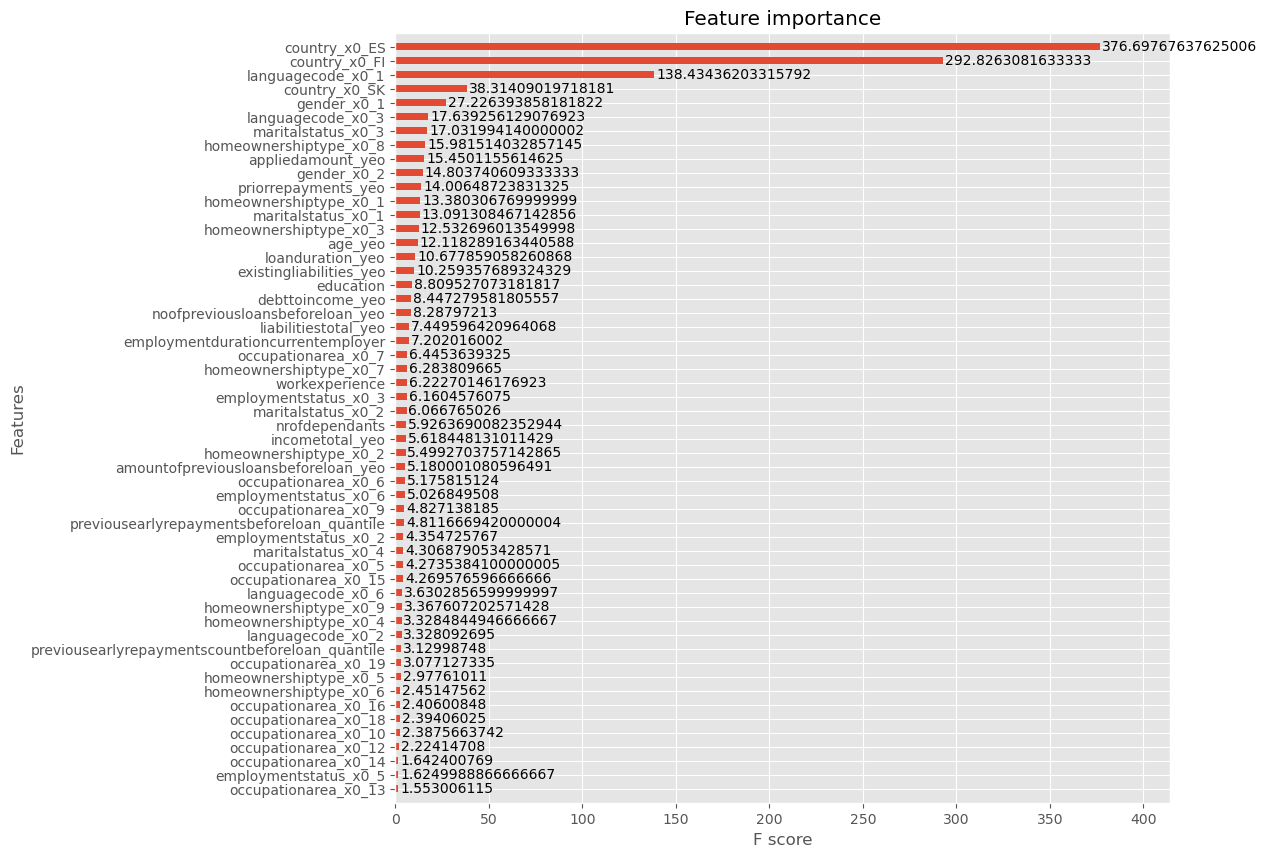

In [112]:
# plot feature importance by gain
plt.style.use('ggplot')
fig, ax= plt.subplots(figsize=(10,10))

# getting names of the features
models_dict['XGB_tuned_isotonic_fitted'].named_steps['estimator'].calibrated_classifiers_[0].base_estimator.get_booster().feature_names = models_dict['XGB_tuned_isotonic_fitted'].named_steps['preprocessor'].named_steps['dataframemapper-3'].transformed_names_

# plotting the feature importances
xgb_plot_importance(models_dict['XGB_tuned_isotonic_fitted'].named_steps['estimator'].calibrated_classifiers_[0].base_estimator, importance_type='gain', height=0.5, show_values=True, ax=ax)
plt.show()

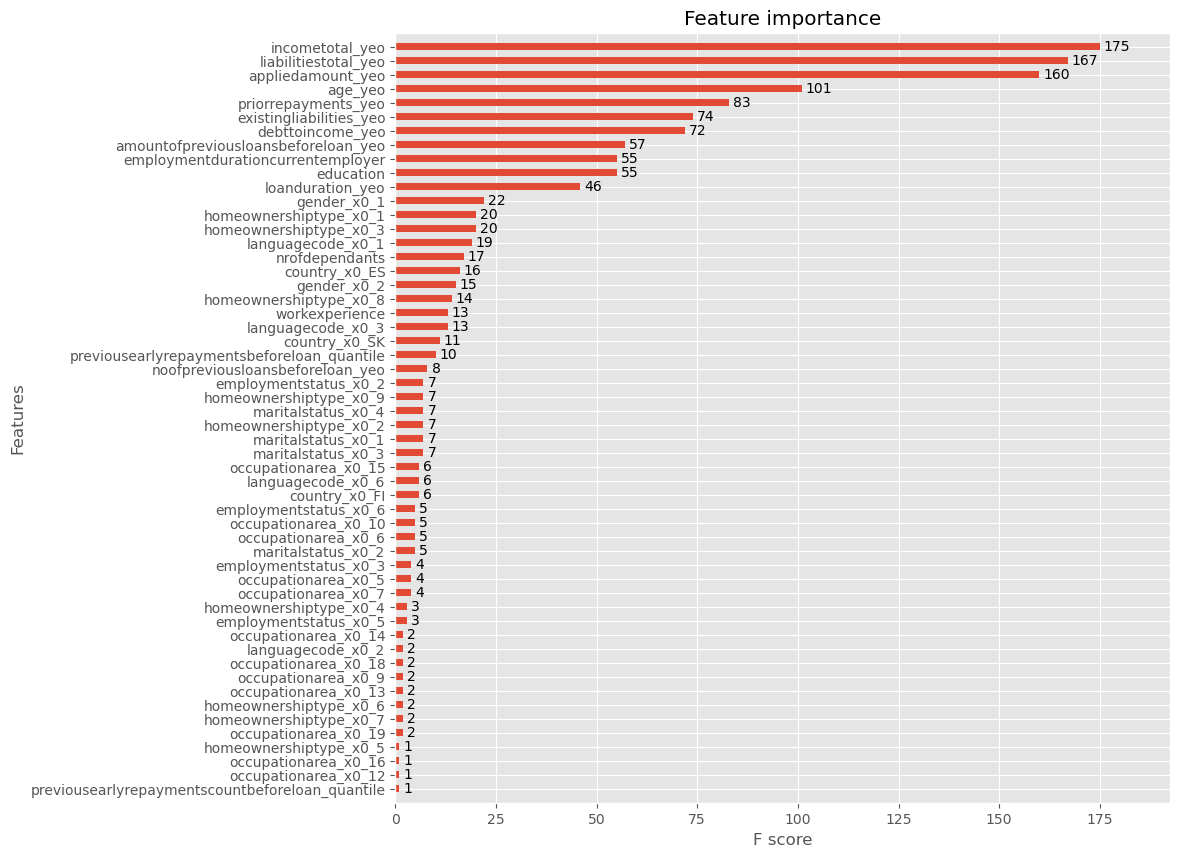

In [113]:
# plot feature importance by weight
plt.style.use('ggplot')
fig, ax= plt.subplots(figsize=(10,10))

# getting names of the features
models_dict['XGB_tuned_isotonic_fitted'].named_steps['estimator'].calibrated_classifiers_[0].base_estimator.get_booster().feature_names = models_dict['XGB_tuned_isotonic_fitted'].named_steps['preprocessor'].named_steps['dataframemapper-3'].transformed_names_

# plotting the feature importances
xgb_plot_importance(models_dict['XGB_tuned_isotonic_fitted'].named_steps['estimator'].calibrated_classifiers_[0].base_estimator, importance_type='weight', height=0.5, show_values=True, ax=ax)
plt.show()

The feature importances according to the LR-Tuned, DT-Tuned, RF-Tuned models are also derived below:

<BarContainer object of 20 artists>

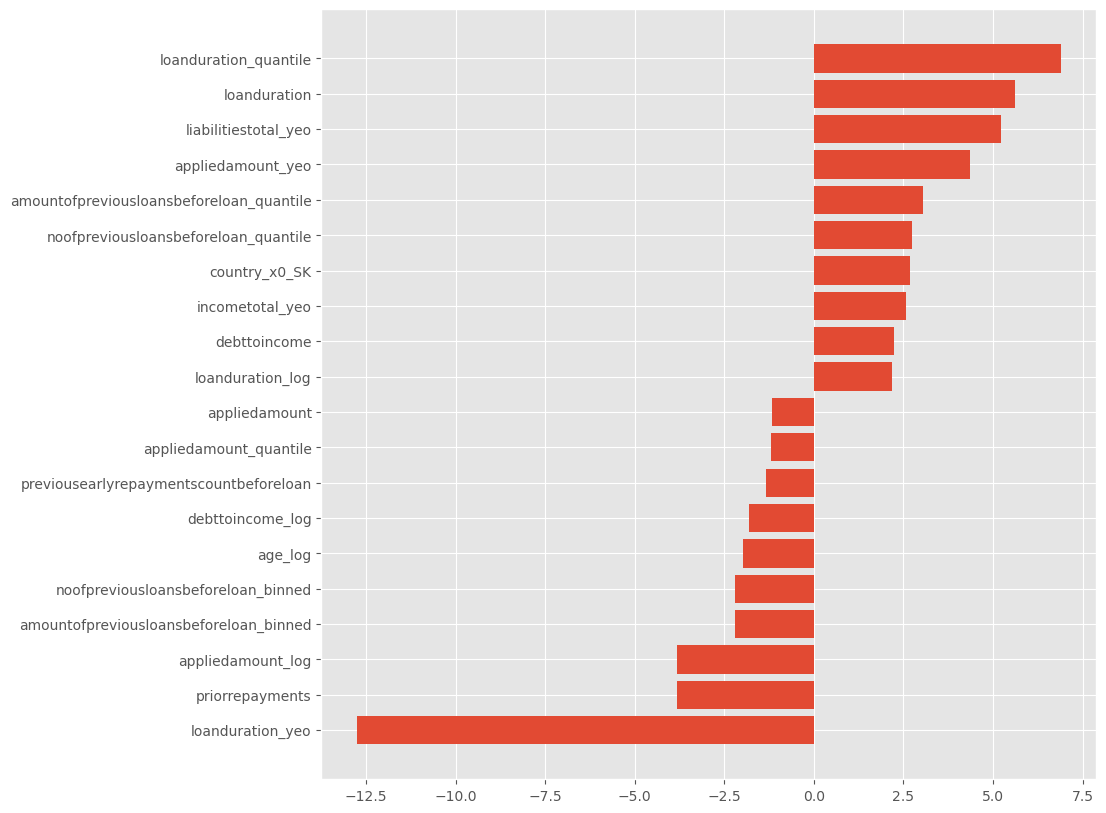

In [128]:
# extract feature importances from LR_tuned

feat_impt = models_dict['LR_tuned_fitted'].named_steps['estimator'].coef_[0]
# extract feature names
input_col_names = models_dict['LR_tuned_fitted'].named_steps['preprocessor'].named_steps['dataframemapper-3'].transformed_names_

r = pd.DataFrame(feat_impt,input_col_names)

r = r[0].sort_values(ascending=True)
# plot the top few negative and positve features
r = pd.concat([r.head(10), r.tail(10)])

fig, ax=plt.subplots(figsize=(10,10))
plt.barh(r.index, r)

<BarContainer object of 115 artists>

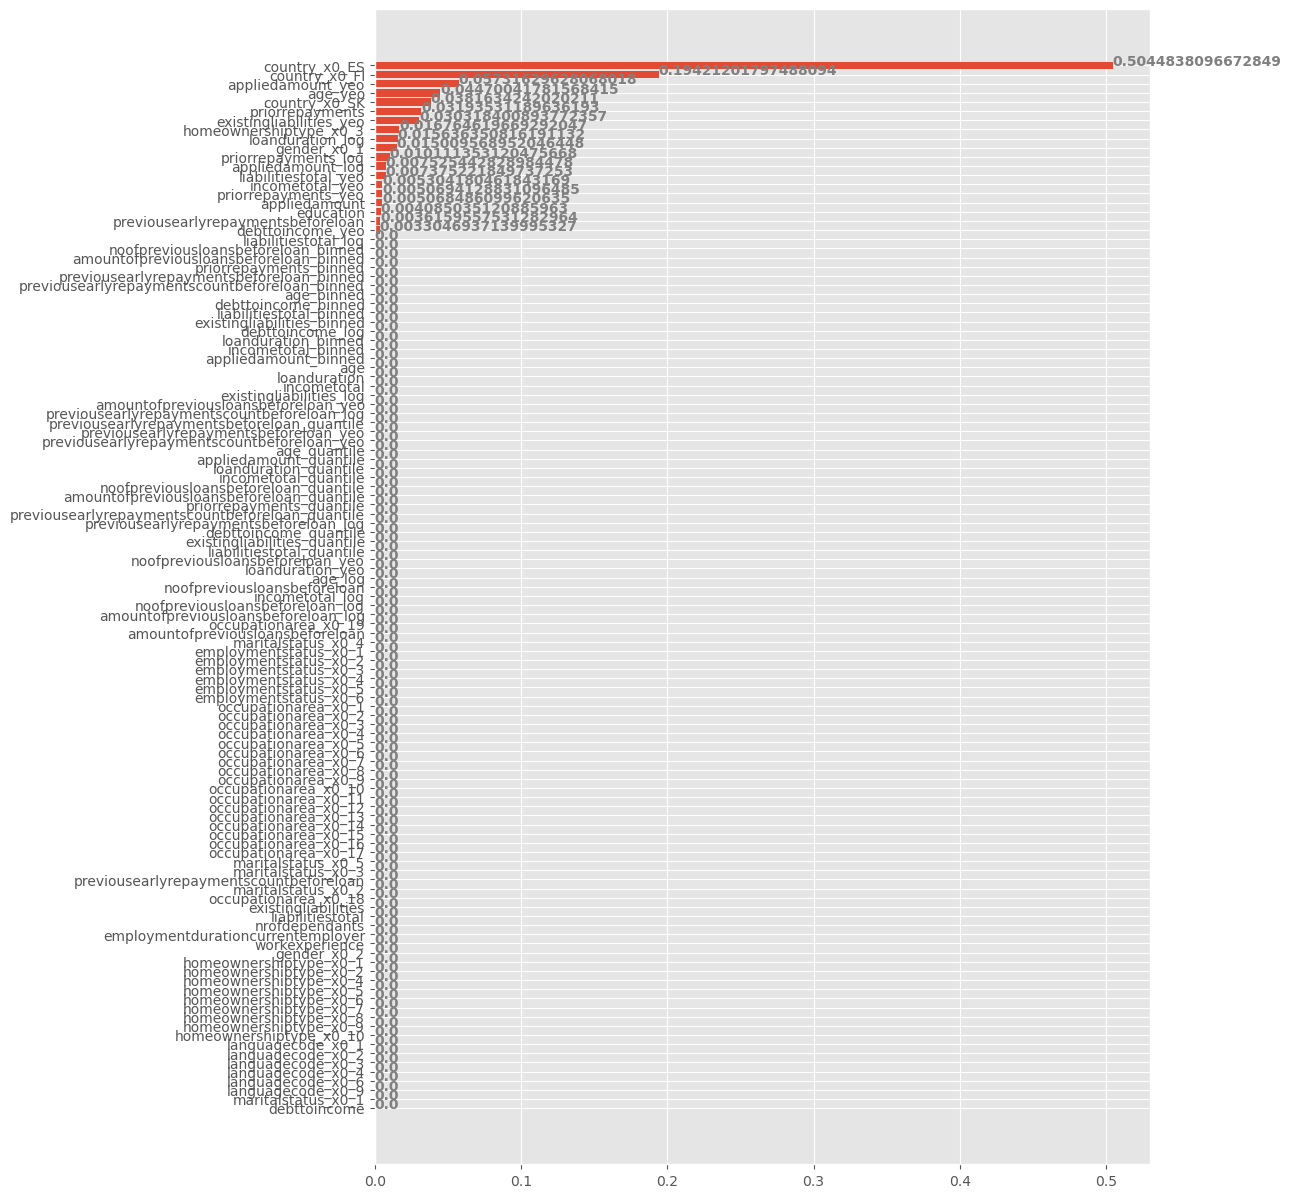

In [130]:
# extract feature importances from DT_tuned
feat_impt = models_dict['DT_tuned_fitted'].named_steps['estimator'].feature_importances_
# extract feature names
input_col_names = models_dict['DT_tuned_fitted'].named_steps['preprocessor'].named_steps['dataframemapper-3'].transformed_names_
# create dataframe and sort features according to importance, filtering those with 0
r = pd.DataFrame(feat_impt,input_col_names)
r = r[0].sort_values(ascending=True)

plt.style.use('ggplot')
fig, ax=plt.subplots(figsize=(10,15))
for i, v in enumerate(r):
    ax.text(v, i , str(v), color='grey', fontweight='bold')

plt.barh(r.index, r)

<BarContainer object of 115 artists>

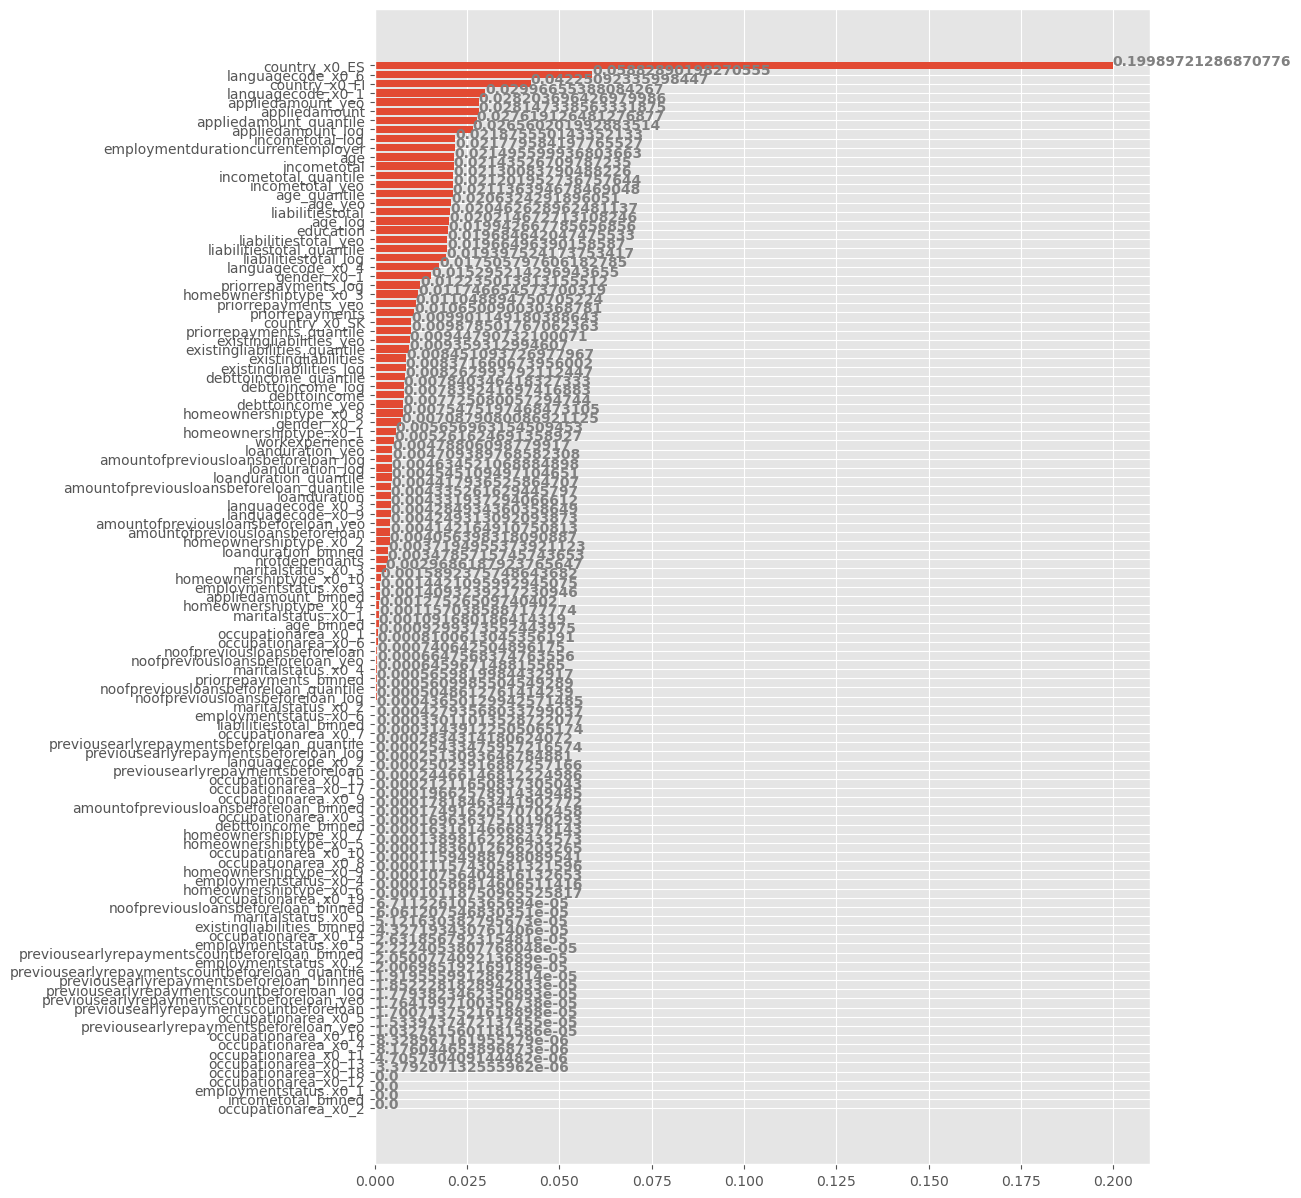

In [129]:
# extract feature importances from RF_tuned
feat_impt = models_dict['RF_tuned_fitted'].named_steps['estimator'].feature_importances_
# extract feature names
input_col_names = models_dict['RF_tuned_fitted'].named_steps['preprocessor'].named_steps['dataframemapper-3'].transformed_names_
# create dataframe and sort features according to importance, filtering those with 0
r = pd.DataFrame(feat_impt,input_col_names)
r = r[0].sort_values(ascending=True)

plt.style.use('ggplot')
fig, ax=plt.subplots(figsize=(10,15))
for i, v in enumerate(r):
    ax.text(v, i , str(v), color='grey', fontweight='bold')

plt.barh(r.index, r)